In [71]:
import json
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [72]:
# pandas settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 5)
# pd.set_option('display.width', )
pd.set_option('display.max_colwidth', None)

# set matplotlib style
# plt.style.use('seaborn-whitegrid')
# set font styles and size
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.weight'] = 'normal'
plt.rcParams['font.size'] = 12

# set seaborn style
sns.set_style('whitegrid')
sns.set_context('paper', font_scale=1.5)

# set seaborn color palette
sns.set_palette('colorblind')

In [82]:
results_dir = './data/outputs'

name_map = {
    'Llama-2-7b-hf': 'Llama-2 (base)',
    'llama_2_7b_hf_guanaco_merged': 'Llama-2 Guanaco',
    # 'llama_2_7b_hf_mono_merged': 'mono (en)',
    'llama_2_7b_hf_ml1_merged': 'Llama-2 Mono',
    'llama_2_7b_hf_ml2_merged': 'Llama-2 ML2',
    'llama_2_7b_hf_ml3_merged': 'Llama-2 ML3',
    'llama_2_7b_hf_ml4_merged': 'Llama-2 ML4',
    'llama_2_7b_hf_ml5_merged': 'Llama-2 ML5',
    # 'llama_2_7b_hf_en_merged': 'ML6/en',
    'llama_2_7b_hf_es_merged': 'Llama-2 ML6/es',
    'llama_2_7b_hf_ru_merged': 'Llama-2 ML6/ru',
    'llama_2_7b_hf_de_merged': 'Llama-2 ML6/de',
    'llama_2_7b_hf_zh_merged': 'Llama-2 ML6/zh',
    'llama_2_7b_hf_fr_merged': 'Llama-2 ML6/fr',
    'llama_2_7b_hf_ca_merged': 'Llama-2 ML6/ca',
    'falcon_7b_guanaco': 'Falcon Guanaco',
    'falcon_7b_ml1_merged': 'Falcon Mono',
    'falcon_7b_ml2_merged': 'Falcon ML2',
    'falcon_7b_ml3_merged': 'Falcon ML3',
    'falcon_7b_ml4_merged': 'Falcon ML4',
    'falcon_7b_ml5_merged': 'Falcon ML5',
    'falcon_7b_es_merged': 'Falcon ML6/es',
    'falcon_7b_ru_merged': 'Falcon ML6/ru',
    'falcon_7b_de_merged': 'Falcon ML6/de',
    'falcon_7b_zh_merged': 'Falcon ML6/zh',
    'falcon_7b_fr_merged': 'Falcon ML6/fr',
    'falcon_7b_ca_merged': 'Falcon ML6/ca',
    'llama_2_7b_hf_mt_es_merged': 'Llama-2 MT ML6/es', # translated training data
    'llama_2_7b_hf_mt_ru_merged': 'Llama-2 MT ML6/ru', # translated training data
    'llama_2_7b_hf_mt_de_merged': 'Llama-2 MT ML6/de', # translated training data
    'llama_2_7b_hf_mt_zh_merged': 'Llama-2 MT ML6/zh', # translated training data
    'llama_2_7b_hf_mtol_de_merged': 'Llama-2 MTOL ML6/de', # translated training data
    'llama_2_7b_hf_mtol_ca_merged': 'Llama-2 MTOL ML6/ca', # translated training data
    'llama_2_7b_hf_mt_ml2_merged': 'Llama-2 MT ML2', # translated training data
    'llama_2_7b_hf_mt_ml3_merged': 'Llama-2 MT ML3', # translated training data
    'llama_2_7b_hf_mt_ml4_merged': 'Llama-2 MT ML4', # translated training data
    'llama_2_7b_hf_mt_ml5_merged': 'Llama-2 MT ML5', # translated training data
    'llama_2_7b_hf_mt_ml6_merged': 'Llama-2 MT ML6', # translated training data
    'llama_2_70b_hf_mt_ml1_merged': 'Llama-2 70B Mono', 
    'llama_2_70b_hf_mt_ml2_merged': 'Llama-2 70B MT ML2', # translated training data
    'llama_2_70b_hf_mt_ml3_merged': 'Llama-2 70B MT ML3', # translated training data
    'llama_2_70b_hf_mt_ml4_merged': 'Llama-2 70B MT ML4', # translated training data
    'llama_2_70b_hf_mt_ml5_merged': 'Llama-2 70B MT ML5', # translated training data
    'llama_2_70b_hf_mt_ml6_merged': 'Llama-2 70B MT ML6', # translated training data
    'alpaca_eval_instructions_en': 'en',
    'alpaca_eval_instructions_es': 'es',
    'alpaca_eval_instructions_ru': 'ru',
    'alpaca_eval_instructions_de': 'de',
    'alpaca_eval_instructions_zh': 'zh',
    'alpaca_eval_instructions_fr': 'fr',
    'alpaca_eval_instructions_ca': 'ca',
    'alpaca_eval_instructions_sv': 'sv*',
    'alpaca_eval_instructions_bg': 'bg*',
    'alpaca_eval_instructions_no': 'no*',
    'alpaca_eval_instructions_da': 'da*',
    'alpaca_eval_instructions_is': 'is**',
    'alpaca_eval_instructions_hi': 'hi**',
    'alpaca_eval_instructions_el': 'el**',
}

training_langs = {
    'Mono': ['en'],
    'ML2': ['en', 'es'],
    'ML3': ['en', 'es', 'ru'],
    'ML4': ['en', 'es', 'ru', 'de'],
    'ML5': ['en', 'es', 'ru', 'de', 'zh'],
    'ML6': ['en', 'es', 'ru', 'de', 'zh', 'fr'],
    'ML6/de': ['en', 'es', 'ru', 'zh', 'fr', 'ca'],
    'ML6/fr': ['en', 'es', 'ru', 'de', 'zh', 'ca'],
    'ML6/zh': ['en', 'es', 'ru', 'de', 'fr', 'ca'],
    'ML6/es': ['en', 'ru', 'de', 'zh', 'fr', 'ca'],
    'ML6/ru': ['en', 'es', 'de', 'zh', 'fr', 'ca'],
    'ML6/ca': ['en', 'es', 'ru', 'de', 'zh', 'fr'],
    'Guanaco': ['en', 'es', 'ru', 'de', 'zh', 'fr', 'ca', '+'], # all
}

# llama langs
# ordered_test_sets = ['en', 'de', 'fr', 'sv*', 'zh', 'es', 'ru', 'ca', 'no*', 'bg*', 'da*', 'is**', 'hi**', 'el**'] # note, 'is', 'hi', 'el' are not actually in llama langs list
# llama_langs_ordered = ['en', 'es', 'ru', 'de', 'zh', 'fr', 'ca', 'sv*', 'no*', 'bg*', 'da*', 'is**', 'hi**', 'el**'] # note, 'is', 'hi', 'el' are not actually in llama langs list
# guanaco_langs_ordered = ['en', 'es', 'ru', 'de', 'zh', 'fr', 'ca']

def load_json(file):
    with open(file, "r", encoding='utf8') as f:
        return json.load(f)

def parse_filename(file):
    """
    data/outputs/llama_2_7b_hf_en_merged/alpaca_eval_instructions_ru-none-guanaco_prompt-s0-k50-p0.9-t0.8-b8.eval
    """
    # get test set and context, allowing for no context
    model_name = Path(file).parent.name
    parts = Path(file).stem.split('-')

    test_set = parts[0]
    context = parts[1]
    prompt = parts[2]
    seed = int(parts[3][1:])
    top_k = int(parts[4][1:])
    top_p = float(parts[5][1:])
    temp = float(parts[6][1:])
    bs = int(parts[7][1:])

    has_translation, n_eval_items, data_seed, api_seed, eval_src, eval_tgt = None, None, None, None, None, None
    if len(parts) > 8:

        # with_en-l300-ds42-as42-source_en-system_en
        has_translation = parts[8] == 'with_en'
        n_eval_items = int(parts[-5][1:])
        data_seed = int(parts[-4][2:])
        api_seed = int(parts[-3][2:])
        eval_src = parts[-2]
        eval_tgt = parts[-1]

    return model_name, test_set, prompt, seed, has_translation, n_eval_items, data_seed, api_seed, eval_src, eval_tgt


def get_results(results_dir):
    """
    Collect all eval files in results_dir and parse them into a dataframe
    """
    dfs = []
    for eval_file in Path(results_dir).glob('*/*.eval'):
        # print(eval_file)
        df = pd.read_csv(eval_file, index_col=None)
        model_name, test_set, prompt, seed, has_translation, n_eval_items, data_seed, api_seed, eval_src, eval_tgt = parse_filename(eval_file)
        df['model_name'] = model_name
        df['test_set'] = test_set
        df['context'] = prompt
        df['seed'] = seed
        dfs.append(df)
        
        # # get generation args too
        # try:
        #     hp_file = eval_file.with_suffix(".json")
        #     hps = load_json(hp_file)
        #     eval_dict.update(hps)
        # except:
        #     pass
    
    df = pd.concat(dfs, axis=0, ignore_index=True)

    df.replace({'model_name': name_map, 'test_set': name_map}, inplace=True)

    # add column for training languages
    df['training_langs'] = df.apply(lambda x: training_langs[x['model_name'].split()[-1]], axis=1)

    # move input_file, model_name and seed to front
    cols = df.columns.tolist()
    cols.insert(0, cols.pop(cols.index('model_name')))
    cols.insert(1, cols.pop(cols.index('test_set')))
    cols.insert(2, cols.pop(cols.index('seed')))
    cols.insert(3, cols.pop(cols.index('training_langs')))
    df = df.reindex(columns=cols)

    df.info()
    
    return df

df = get_results(results_dir)
print(len(df))
print(df.columns)
df.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   model_name      1470 non-null   object 
 1   test_set        1470 non-null   object 
 2   seed            1470 non-null   int64  
 3   training_langs  1470 non-null   object 
 4   lang_match      1470 non-null   float64
 5   tgt_lang        1470 non-null   float64
 6   ppl             1344 non-null   float64
 7   file            1470 non-null   object 
 8   context         1470 non-null   object 
 9   ppl_model       846 non-null    object 
 10  n               1215 non-null   float64
dtypes: float64(4), int64(1), object(6)
memory usage: 126.5+ KB
1470
Index(['model_name', 'test_set', 'seed', 'training_langs', 'lang_match',
       'tgt_lang', 'ppl', 'file', 'context', 'ppl_model', 'n'],
      dtype='object')


,model_name,test_set,seed,training_langs,lang_match,tgt_lang,ppl,file,context,ppl_model,n
0,Llama-2 Mono,de,0,[en],0.391,0.390,24.971,data/outputs/llama_2_7b_hf_ml1_merged/alpaca_eval_instructions_de-none-guanaco_prompt-s0-k50-p0.9-t0.8-b8.jsonl,guanaco_prompt,NaN,NaN
1,Llama-2 Mono,de,42,[en],0.416,0.419,22.476,data/outputs/llama_2_7b_hf_ml1_merged/alpaca_eval_instructions_de-none-guanaco_prompt-s42-k50-p0.9-t0.8-b8.jsonl,guanaco_prompt,NaN,NaN
2,Llama-2 Mono,de,723,[en],0.411,0.412,22.836,data/outputs/llama_2_7b_hf_ml1_merged/alpaca_eval_instructions_de-none-guanaco_prompt-s723-k50-p0.9-t0.8-b8.jsonl,guanaco_prompt,NaN,NaN
3,Llama-2 Mono,en,0,[en],0.944,0.964,14.927,data/outputs/llama_2_7b_hf_ml1_merged/alpaca_eval_instructions_en-none-guanaco_prompt-s0-k50-p0.9-t0.8-b8.jsonl,guanaco_prompt,NaN,NaN
4,Llama-2 Mono,en,42,[en],0.933,0.954,20673.208,data/outputs/llama_2_7b_hf_ml1_merged/alpaca_eval_instructions_en-none-guanaco_prompt-s42-k50-p0.9-t0.8-b8.jsonl,guanaco_prompt,NaN,NaN


In [83]:
# sort models given the order in name_map
model_names = df['model_name'].unique()
ordered_model_names = sorted(model_names, key=lambda x: list(name_map.values()).index(x))
# manually add Llama-2 (base) to the front
ordered_model_names.insert(0, name_map['Llama-2-7b-hf'])
print(ordered_model_names)
test_sets = df['test_set'].unique()
ordered_test_sets = sorted(test_sets, key=lambda x: list(name_map.values()).index(x))
print(ordered_test_sets)
ordered_seeds = sorted(df['seed'].unique())
print(ordered_seeds)

def apply_sort(df):

    df['model_name'] = pd.Categorical(df['model_name'], ordered_model_names)
    df['test_set'] = pd.Categorical(df['test_set'], ordered_test_sets)

    if 'seed' in df.columns:
        df = df.sort_values(by=['model_name', 'test_set', 'seed'])
    else:
        df = df.sort_values(by=['model_name', 'test_set'])

    # Convert the columns back to their original data types
    df['model_name'] = df['model_name'].astype(str)
    df['test_set'] = df['test_set'].astype(str)
        
    df = df.reset_index(drop=True)

    df.info()
    
    return df

# drop columns containing any NaN values
# df = df.dropna(axis=1, how='any')

# sort dataframe
df = apply_sort(df)
# store sort order
# custom_sort_index = df.index.tolist()
# df['idx'] = custom_sort_index
# print(df.columns)
df

['Llama-2 (base)', 'Llama-2 Guanaco', 'Llama-2 Mono', 'Llama-2 ML2', 'Llama-2 ML3', 'Llama-2 ML4', 'Llama-2 ML5', 'Llama-2 ML6/es', 'Llama-2 ML6/ru', 'Llama-2 ML6/de', 'Llama-2 ML6/zh', 'Llama-2 ML6/fr', 'Llama-2 ML6/ca', 'Falcon Mono', 'Falcon ML2', 'Falcon ML6/ru', 'Falcon ML6/de', 'Falcon ML6/zh', 'Falcon ML6/ca', 'Llama-2 MT ML6/es', 'Llama-2 MT ML6/ru', 'Llama-2 MT ML6/de', 'Llama-2 MT ML6/zh', 'Llama-2 MTOL ML6/de', 'Llama-2 MTOL ML6/ca', 'Llama-2 MT ML2', 'Llama-2 MT ML3', 'Llama-2 MT ML4', 'Llama-2 MT ML5', 'Llama-2 MT ML6', 'Llama-2 70B Mono', 'Llama-2 70B MT ML2', 'Llama-2 70B MT ML3', 'Llama-2 70B MT ML4', 'Llama-2 70B MT ML5', 'Llama-2 70B MT ML6']
['en', 'es', 'ru', 'de', 'zh', 'fr', 'ca', 'sv*', 'bg*', 'no*', 'da*', 'is**', 'hi**', 'el**']
[0, 42, 723]
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   model_name      1470 

,model_name,test_set,seed,training_langs,lang_match,tgt_lang,ppl,file,context,ppl_model,n
0,Llama-2 Guanaco,en,0,"[en, es, ru, de, zh, fr, ca, +]",0.938,0.954,NaN,data/outputs/llama_2_7b_hf_guanaco_merged/alpaca_eval_instructions_en-none-guanaco_prompt-s0-k50-p0.9-t0.8-b8.jsonl,guanaco_prompt,NaN,805.0
1,Llama-2 Guanaco,en,42,"[en, es, ru, de, zh, fr, ca, +]",0.944,0.968,NaN,data/outputs/llama_2_7b_hf_guanaco_merged/alpaca_eval_instructions_en-none-guanaco_prompt-s42-k50-p0.9-t0.8-b8.jsonl,guanaco_prompt,NaN,805.0
...,...,...,...,...,...,...,...,...,...,...,...
1468,Llama-2 70B MT ML6,el**,42,"[en, es, ru, de, zh, fr]",0.980,0.981,24.176,data/outputs/llama_2_70b_hf_mt_ml6_merged/alpaca_eval_instructions_el-none-guanaco_prompt-s42-k50-p0.9-t0.8-b128.jsonl,guanaco_prompt,ai-forever/mGPT,805.0
1469,Llama-2 70B MT ML6,el**,723,"[en, es, ru, de, zh, fr]",0.981,0.980,31.171,data/outputs/llama_2_70b_hf_mt_ml6_merged/alpaca_eval_instructions_el-none-guanaco_prompt-s723-k50-p0.9-t0.8-b128.jsonl,guanaco_prompt,ai-forever/mGPT,805.0


In [84]:
def get_results_overview(df, cols=['model_name', 'test_set', 'seed']):
    for col in cols:
        print(f'*** {col} ***')
        print(df[col].value_counts())
        print()

get_results_overview(df)

*** model_name ***
Llama-2 Guanaco       42
Llama-2 MT ML4        42
                      ..
Falcon ML6/de         42
Llama-2 70B MT ML6    42
Name: model_name, Length: 35, dtype: int64

*** test_set ***
en      105
es      105
       ... 
hi**    105
el**    105
Name: test_set, Length: 14, dtype: int64

*** seed ***
0      490
42     490
723    490
Name: seed, dtype: int64



In [85]:
def get_agg_df(
        df, 
        group_cols=['model_name', 'test_set'], 
        agg_ops={
            'lang_match': [np.mean, np.std], 
            'tgt_lang': [np.mean, np.std], 
            'ppl': [np.mean, np.std],
            }
        ):
    """
    Aggregates the results of the different strategies.
    If use_macro is True, then the macro-averaged results are used, otherwise the micro-averaged results are used.
    """
    df = df.groupby(group_cols, as_index=True).agg(agg_ops)
    # df = df.reindex(['0-shot', '1-shot', 'Mem-4', 'Mem-8', 'L2M'])
    # df[df.select_dtypes(include=['number']).columns] *= 100
    df = df.round(2)
    return df

def styled_df(df, color):
    return df.style.background_gradient(axis=0, text_color_threshold=0, cmap=sns.light_palette(color, as_cmap=True)).highlight_max(axis=0, props='font-weight:bold;').format(precision=2)

# unset multi-index
# agg_df = get_agg_df(df).reset_index()
# join levels of multi-index columns
# agg_df.columns = ['_'.join(col).strip() if isinstance(col, tuple) else col for col in agg_df.columns]
# styled_df(agg_df, 'seagreen')

data/plots/llama2_7b_lang_match_incremental_ml_wide.png saved.


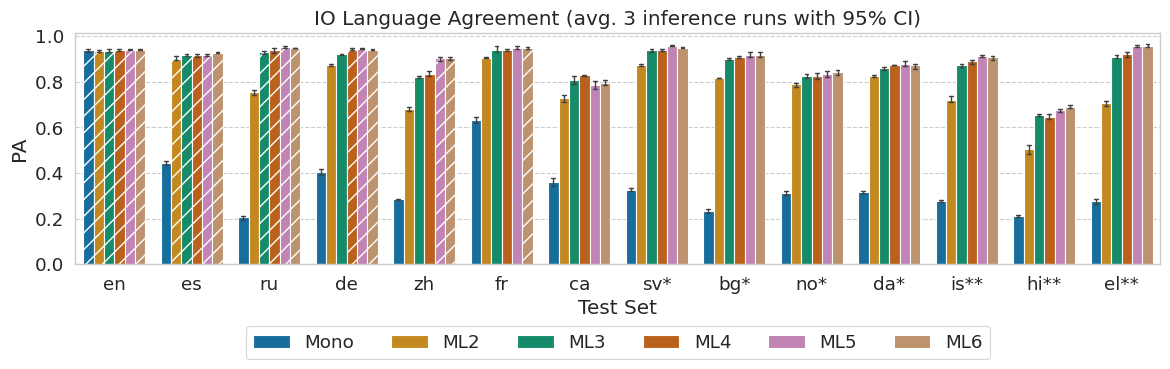

In [86]:
# plot bar plots of lang_match
def make_basic_barplot_long(df, title=None, save_path=None):
    
    # Get the unique values for 'test_set' and 'model_name'
    test_sets = [l for l in ordered_test_sets if l in df['test_set'].unique()]
    model_names = df['model_name'].unique()

    # number of bars to plot with hue
    expected_num_bars = len(test_sets) * len(model_names)

    fig, ax = plt.subplots(figsize=(4, expected_num_bars//4))

    sns.barplot(data=df,
                x='lang_match', y='test_set', 
                hue='model_name', 
                errorbar=("ci", 95), capsize=0.3,
                err_kws={"linewidth": 1.0},
                alpha=1.0,
                order=test_sets,
                hue_order=model_names,
                orient='h',
                ax=ax)

    # remove bars from sorted that correspond to the legend
    bars = [patch for patch in ax.patches if patch.xy != (0, 0)]

    sorted_bars = sorted(bars, key=lambda bar: bar.get_y(), reverse=False)
    
    # Create a dictionary to map each bar to its 'test_set' and 'model_name'
    bar_info = {}
    for i, test_set in enumerate(test_sets):
        for j, model_name in enumerate(model_names):
    #         # The index of the bar in the patches list
            index = i * len(model_names) + j
            bar_info[sorted_bars[index]] = {'test_set': test_set, 'model_name': model_name}

    # Loop over the bars and add a text label as a marker
    for i, (bar, info) in enumerate(bar_info.items()):
        if info['test_set'] in training_langs[info['model_name'].split()[-1]]:
            bar.set_hatch('//')
        else:
            bar.set_hatch('')

    if title:
        ax.set_title(title)

    ax.set_xlabel('Language Match')
    ax.set_ylabel('Test Set')

    # add vertical gridlines
    ax.xaxis.grid(True, linestyle='--', which='major', color='grey', alpha=.4)

    # legend at bottom
    ax.legend(loc='lower center', bbox_to_anchor=(0.5, -0.3), ncol=3)

    if save_path:
        fig.savefig(save_path, bbox_inches='tight', dpi=300)
        print(f'{save_path} saved.')

    return

def make_basic_barplot_wide(df, title=None, save_path=None):
    
    # Get the unique values for 'test_set' and 'model_name'
    test_sets = [l for l in ordered_test_sets if l in df['test_set'].unique()]
    model_names = df['model_name'].unique()

    # number of bars to plot with hue
    expected_num_bars = len(test_sets) * len(model_names)

    fig, ax = plt.subplots(figsize=(len(test_sets), 3))

    sns.barplot(data=df,
                x='test_set', y='lang_match', 
                hue='model_name', 
                errorbar=("ci", 95), capsize=0.3,
                err_kws={"linewidth": 1.0},
                alpha=1.0,
                order=test_sets,
                hue_order=model_names,
                ax=ax)

    # remove bars from sorted that correspond to the legend
    bars = [patch for patch in ax.patches if patch.xy != (0, 0)]

    sorted_bars = sorted(bars, key=lambda bar: bar.get_x(), reverse=False)
    
    # Create a dictionary to map each bar to its 'test_set' and 'model_name'
    bar_info = {}
    for i, test_set in enumerate(test_sets):
        for j, model_name in enumerate(model_names):
    #         # The index of the bar in the patches list
            index = i * len(model_names) + j
            bar_info[sorted_bars[index]] = {'test_set': test_set, 'model_name': model_name}

    # Loop over the bars and add a text label as a marker
    for i, (bar, info) in enumerate(bar_info.items()):
        if info['test_set'] in training_langs[info['model_name'].split()[-1]]:
            bar.set_hatch('//')
        else:
            bar.set_hatch('')

    if title:
        ax.set_title(title)

    ax.set_xlabel('Test Set')
    ax.set_ylabel('PA')

    # add horizontal gridlines
    ax.yaxis.grid(True, linestyle='--', which='major', color='grey', alpha=.4)

    # legend at bottom
    if len(test_sets) >= 6:
        ncols = len(model_names)
        y_offset = -0.45
    else:
        ncols = 3
        y_offset = -0.55
    ax.legend(loc='lower center', bbox_to_anchor=(0.5, y_offset), ncol=ncols)

    if save_path:
        fig.savefig(save_path, bbox_inches='tight', dpi=300)
        print(f'{save_path} saved.')

    return

# plot Llama-2 models with incremental multilingual training
sdf = df[df['model_name'].isin(['Llama-2 Mono', 'Llama-2 ML2', 'Llama-2 ML3', 'Llama-2 ML4', 'Llama-2 ML5', 'Llama-2 ML6/ca'])]
sdf = sdf[sdf['test_set'].isin(ordered_test_sets)]
# sdf = sdf[sdf['test_set'].isin(['sv', 'da', 'no', 'bg', 'is', 'hi', 'el'])]
sdf['model_name'] = sdf['model_name'].str.replace('Llama-2 ', '').str.replace('/ca', '')

make_basic_barplot_wide(
    sdf, 
    title='IO Language Agreement (avg. 3 inference runs with 95% CI)', 
    save_path='data/plots/llama2_7b_lang_match_incremental_ml_wide.png')

# make_basic_barplot_long(
#     sdf, 
#     title='On-target performance (avg. 3 inference runs with 95% CI)', 
#     save_path='data/plots/llama2_7b_lang_match_incremental_ml_long.png')



data/plots/llama2_7b_lang_match_incremental_mt_ml_wide.png saved.


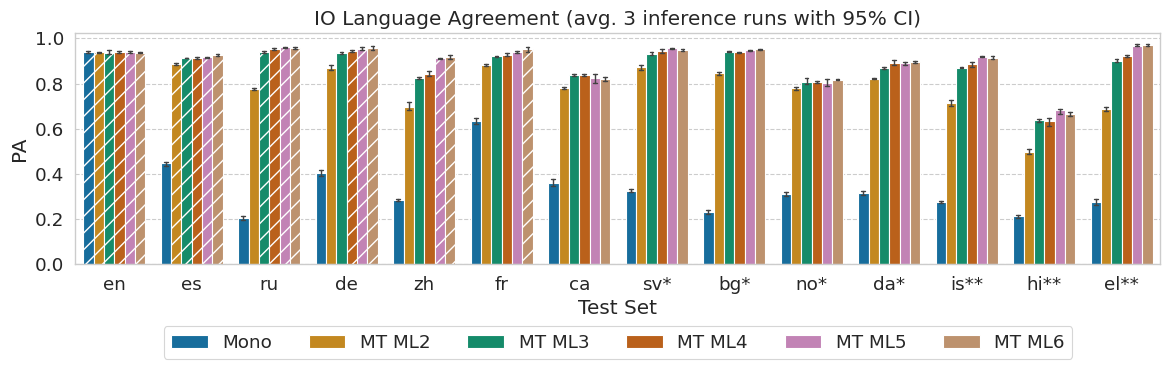

In [87]:
# plot Llama-2 models with incremental MT multilingual training
sdf = df[df['model_name'].isin(['Llama-2 Mono', 'Llama-2 MT ML2', 'Llama-2 MT ML3', 'Llama-2 MT ML4', 'Llama-2 MT ML5', 'Llama-2 MT ML6'])]
sdf = sdf[sdf['test_set'].isin(ordered_test_sets)]
sdf['model_name'] = sdf['model_name'].str.replace('Llama-2 ', '')

make_basic_barplot_wide(
    sdf, 
    title='IO Language Agreement (avg. 3 inference runs with 95% CI)', 
    save_path='data/plots/llama2_7b_lang_match_incremental_mt_ml_wide.png')

data/plots/llama2_70b_lang_match_incremental_mt_ml_wide.png saved.


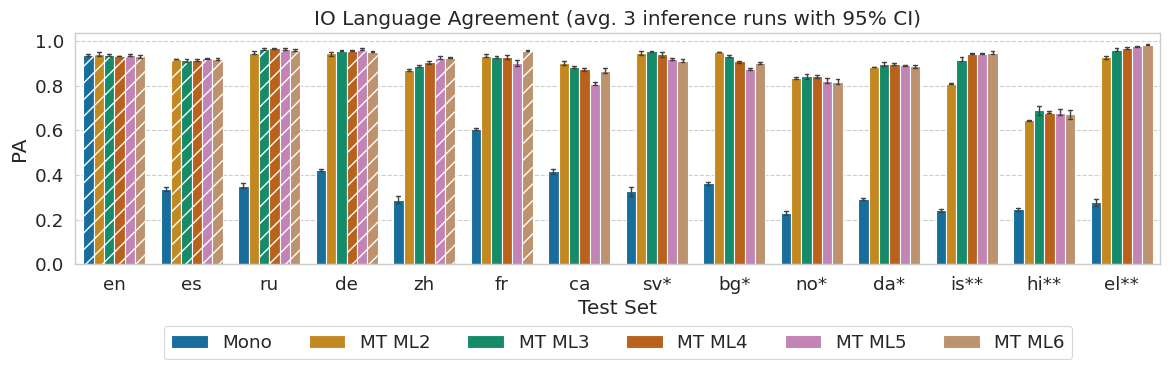

In [88]:
# plot Llama-2 70B models with incremental mt multilingual training

sdf = df[df['model_name'].isin(['Llama-2 70B Mono', 'Llama-2 70B MT ML2', 'Llama-2 70B MT ML3', 'Llama-2 70B MT ML4', 'Llama-2 70B MT ML5', 'Llama-2 70B MT ML6'])]
sdf = sdf[sdf['test_set'].isin(ordered_test_sets)]
sdf['model_name'] = sdf['model_name'].str.replace('Llama-2 70B ', '')
make_basic_barplot_wide(
    sdf, 
    title='IO Language Agreement (avg. 3 inference runs with 95% CI)', 
    save_path='data/plots/llama2_70b_lang_match_incremental_mt_ml_wide.png'
    )

data/plots/llama2_7b_lang_match_loo_wide.png saved.


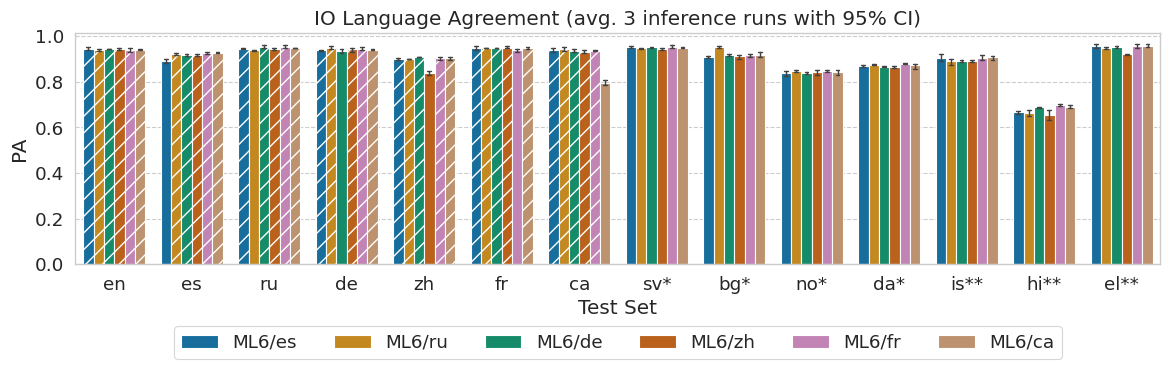

In [89]:
# get only Llama-2 models with incremental multilingual training
# en, es, ru, de, zh, fr
sdf = df[df['model_name'].isin(['Llama-2 ML6/es', 'Llama-2 ML6/ru', 'Llama-2 ML6/de', 'Llama-2 ML6/zh', 'Llama-2 ML6/fr', 'Llama-2 ML6/ca'])]
sdf = sdf[sdf['test_set'].isin(ordered_test_sets)]
sdf['model_name'] = sdf['model_name'].str.replace('Llama-2 ', '')
make_basic_barplot_wide(
    sdf, 
    title='IO Language Agreement (avg. 3 inference runs with 95% CI)', 
    save_path='data/plots/llama2_7b_lang_match_loo_wide.png')

(36, 8)
data/plots/llama2_7b_lang_match_heatmap_loo.png saved.


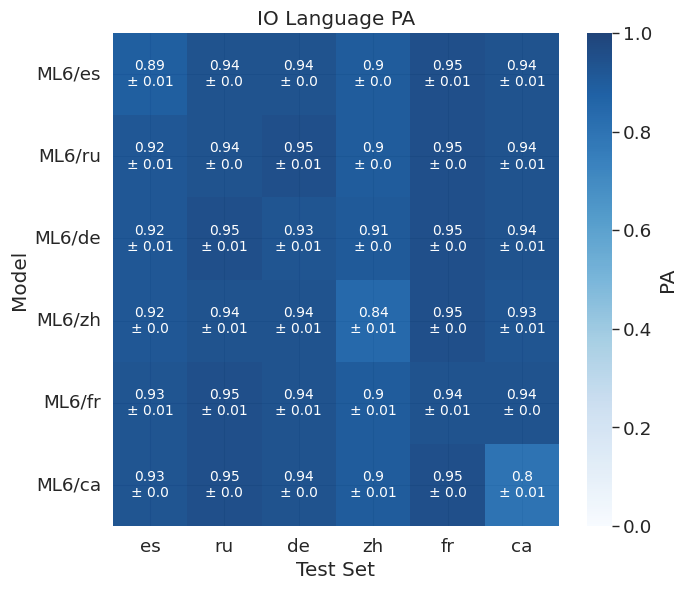

In [91]:
from matplotlib.patches import Rectangle

def make_basic_heatmap(df, metric, include_std=False, title=None, save_path=None, strip_from_model_name=None, include_hatches=False):
        
    print(df.shape)
    fig, ax = plt.subplots(figsize=(df.shape[0]*0.2, df.shape[1]*0.8))
    
    heatmap_mean = df.pivot_table(index='model_name', columns='test_set', values=f'{metric}_mean', sort=False)
    heatmap_std = df.pivot_table(index='model_name', columns='test_set', values=f'{metric}_std', sort=False)

    # sort by order in name_map
    heatmap_mean = heatmap_mean.reindex([n for n in ordered_model_names if n in heatmap_mean.index])
    heatmap_std = heatmap_std.reindex([n for n in ordered_model_names if n in heatmap_std.index])

    # sort columns by order in ordered_test_sets
    heatmap_mean = heatmap_mean.reindex(columns=[l for l in ordered_test_sets if l in heatmap_mean.columns])
    heatmap_std = heatmap_std.reindex(columns=[l for l in ordered_test_sets if l in heatmap_std.columns])

    if strip_from_model_name is not None:
        for segment in strip_from_model_name:
            heatmap_mean.index = heatmap_mean.index.str.replace(segment, '')
            heatmap_std.index = heatmap_std.index.str.replace(segment, '')

    if include_std:
        annotations = heatmap_mean.round(2).astype(str) + "\n± " + heatmap_std.round(2).astype(str)
    else:
        annotations = heatmap_std.round(2).astype(str)

    ax = sns.heatmap(
        heatmap_mean, annot=annotations, fmt='', 
        cmap="Blues", alpha=0.9, cbar=True, 
        cbar_kws={'label': f'PA'}, 
        vmin=0, vmax=1.0, ax=ax
        )


    highlight_color = 'red'
    if include_hatches:
        # Get the x and y axis labels
        x_labels = heatmap_mean.columns.values
        y_labels = heatmap_mean.index.values

        # Iterate over the cells based on some condition
        for y in range(heatmap_mean.shape[0]):  # for each row
            for x in range(heatmap_mean.shape[1]):  # for each column
                # Check if the cell meets your condition to have hatches
                # Replace 'your_condition' with the actual condition
                if x_labels[x] in training_langs[y_labels[y].split()[-1]]:
                    # Add a rectangle with the desired hatch pattern
                    # ax.add_patch(Rectangle((x, y), 1, 1, fill=False, hatch='O.', snap=False))
                    ax.add_patch(Rectangle((x, y), 1, 1, fill=False, edgecolor=highlight_color, lw=2))

        
    # reduce font size of annotations
    for t in ax.texts:
        t.set_fontsize(10)
    
    if title:
        ax.set_title(title)

    ax.set_ylabel('Model')
    ax.set_xlabel('Test Set')

    # ensure yaxis labels are horizontal
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0)

    if save_path:
        fig.savefig(save_path, bbox_inches='tight', dpi=300)
        print(f'{save_path} saved.')

    return

sdf = df[df['model_name'].isin(['Llama-2 ML6/es', 'Llama-2 ML6/ru', 'Llama-2 ML6/de', 'Llama-2 ML6/zh', 'Llama-2 ML6/fr', 'Llama-2 ML6/ca'])]
sdf = sdf[sdf['test_set'].isin(['es', 'de', 'fr', 'ca', 'zh', 'ru'])]

# aggregate
agg_sdf = get_agg_df(sdf).reset_index()
# join levels of multi-index columns
agg_sdf.columns = ['_'.join(col).strip('_') if isinstance(col, tuple) else col for col in agg_sdf.columns]

make_basic_heatmap(
    agg_sdf, 
    metric='lang_match',
    include_std=True,
    title='IO Language PA', 
    save_path='data/plots/llama2_7b_lang_match_heatmap_loo.png',
    strip_from_model_name=['Llama-2 ']
    )


(72, 8)


data/plots/llama2_7b_lang_match_heatmap_incremental_ml_seen_and_unseen.png saved.


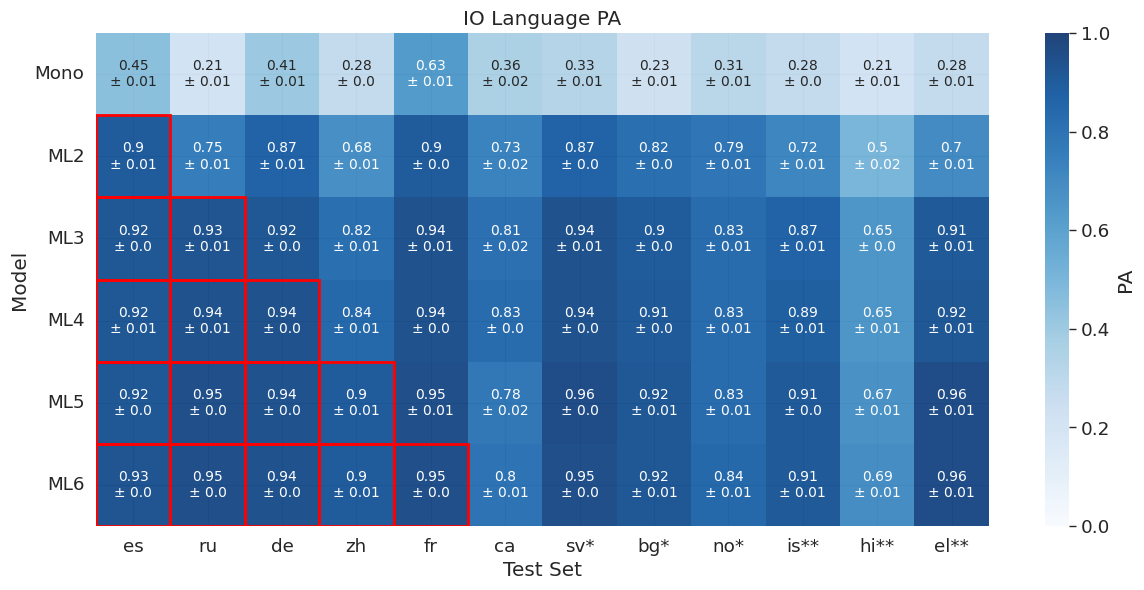

In [92]:
sdf = df[df['model_name'].isin(['Llama-2 Mono', 'Llama-2 ML2', 'Llama-2 ML3', 'Llama-2 ML4', 'Llama-2 ML5', 'Llama-2 ML6/ca'])]
sdf = sdf[sdf['test_set'].isin(['es', 'de', 'fr', 'ca', 'zh', 'ru', 'sv*', 'no*', 'bg*', 'is**', 'hi**', 'el**'])]
# aggregate
agg_sdf = get_agg_df(sdf).reset_index()
# join levels of multi-index columns
agg_sdf.columns = ['_'.join(col).strip('_') if isinstance(col, tuple) else col for col in agg_sdf.columns]

make_basic_heatmap(
    agg_sdf, 
    metric='lang_match',
    include_std=True,
    title='IO Language PA', 
    save_path='data/plots/llama2_7b_lang_match_heatmap_incremental_ml_seen_and_unseen.png',
    strip_from_model_name=['Llama-2 ', '/ca'],
    include_hatches=True
    )

(36, 8)
data/plots/llama2_7b_lang_match_heatmap_incremental_ml_unseen.png saved.


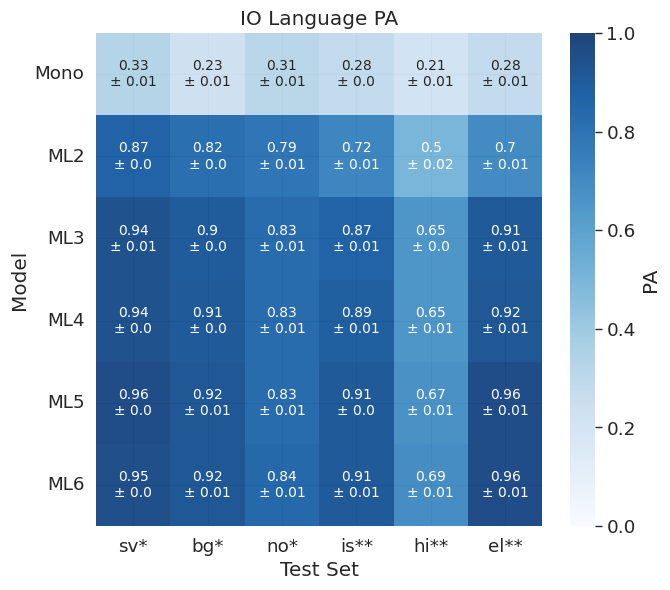

In [93]:
sdf = df[df['model_name'].isin(['Llama-2 Mono', 'Llama-2 ML2', 'Llama-2 ML3', 'Llama-2 ML4', 'Llama-2 ML4', 'Llama-2 ML5', 'Llama-2 ML6/ca'])]
sdf = sdf[sdf['test_set'].isin(['sv*', 'no*', 'bg*', 'is**', 'hi**', 'el**'])]
# aggregate
agg_sdf = get_agg_df(sdf).reset_index()
# join levels of multi-index columns
agg_sdf.columns = ['_'.join(col).strip('_') if isinstance(col, tuple) else col for col in agg_sdf.columns]

make_basic_heatmap(
    agg_sdf, 
    metric='lang_match',
    include_std=True,
    title='IO Language PA', 
    save_path='data/plots/llama2_7b_lang_match_heatmap_incremental_ml_unseen.png',
    strip_from_model_name=['Llama-2 ', '/ca']
    )

(56, 8)
data/plots/falcon_lang_match_heatmap_incremental_ml_unseen.png saved.


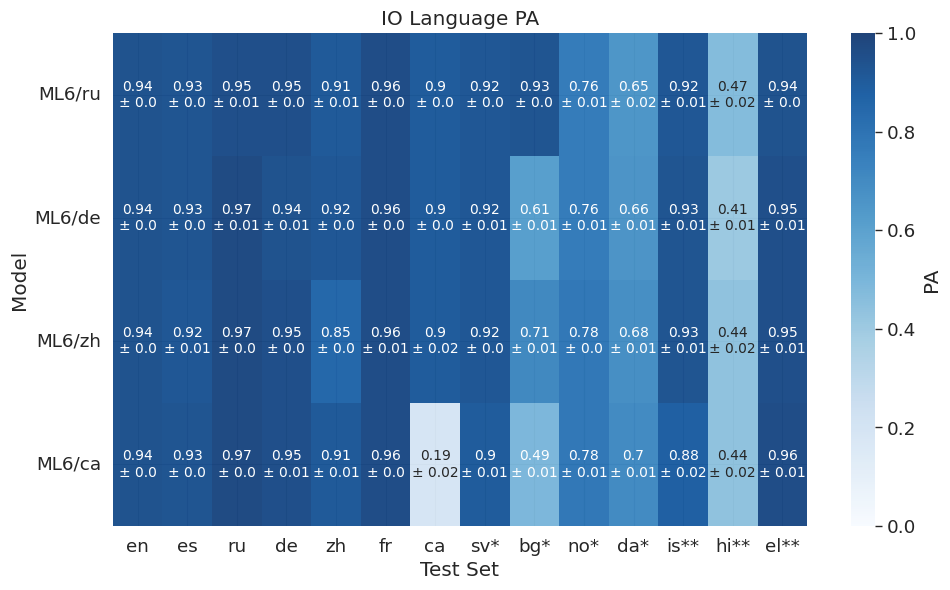

In [94]:
sdf = df[df['model_name'].isin(['Falcon ML6/de', 'Falcon ML6/zh', 'Falcon ML6/ru', 'Falcon ML6/ca'])]
# sdf = sdf[sdf['test_set'].isin([ordered_test_sets])]
# aggregate
agg_sdf = get_agg_df(sdf).reset_index()
# join levels of multi-index columns
agg_sdf.columns = ['_'.join(col).strip('_') if isinstance(col, tuple) else col for col in agg_sdf.columns]

make_basic_heatmap(
    agg_sdf, 
    metric='lang_match',
    include_std=True,
    title='IO Language PA', 
    save_path='data/plots/falcon_lang_match_heatmap_incremental_ml_unseen.png',
    strip_from_model_name=['Falcon ']
    )

(36, 8)
data/plots/falcon_lang_match_heatmap_incremental_mt_ml_seen_and_unseen.png saved.


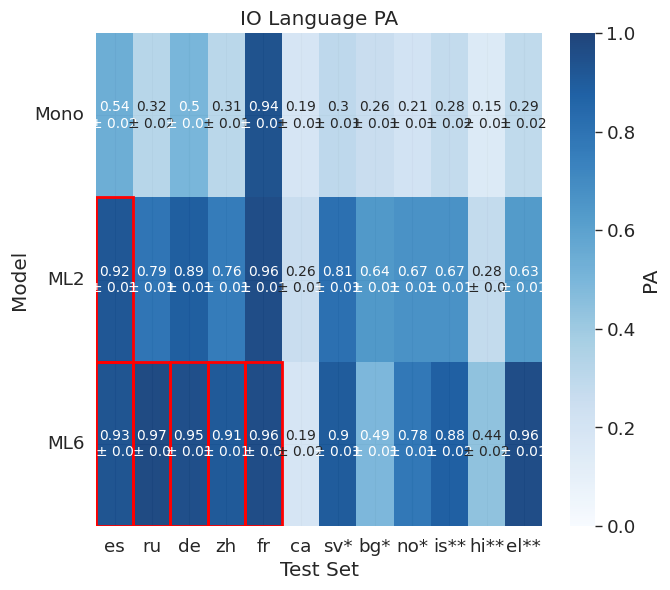

In [95]:
sdf = df[df['model_name'].isin(['Falcon Mono', 'Falcon ML2', 'Falcon ML3', 'Falcon ML4', 'Falcon ML5', 'Falcon ML6/ca'])]
sdf = sdf[sdf['test_set'].isin(['es', 'de', 'fr', 'ca', 'zh', 'ru', 'sv*', 'no*', 'bg*', 'is**', 'hi**', 'el**'])]
# aggregate
agg_sdf = get_agg_df(sdf).reset_index()
# join levels of multi-index columns
agg_sdf.columns = ['_'.join(col).strip('_') if isinstance(col, tuple) else col for col in agg_sdf.columns]

make_basic_heatmap(
    agg_sdf, 
    metric='lang_match',
    include_std=True,
    title='IO Language PA', 
    save_path='data/plots/falcon_lang_match_heatmap_incremental_mt_ml_seen_and_unseen.png',
    strip_from_model_name=['Falcon ', '/ca'],
    include_hatches=True
    )

# process lm-eval harness results

In [96]:
def load_lm_eval_results_file(file):
    with open(file, "r", encoding='utf8') as f:
        df = pd.DataFrame.from_dict(json.load(f)['results'])
        df['model_name'] = Path(file).stem
        return df

def get_lm_eval_results(results_dir):
    dfs = []
    for results_file in Path(results_dir).glob('*.json'):
        print(results_file)
        df = load_lm_eval_results_file(results_file)
        dfs.append(df)
    df = pd.concat(dfs, axis=0, ignore_index=False).reset_index()
    df = df.rename(columns={'index': 'metric'})

    # Reshape the dataframe, moving model_name and index to the index
    df_long = pd.melt(df, id_vars=['model_name', 'metric'], var_name='task_lang', value_name='score')

    # Split the task_lang into two separate columns for 'task' and 'lang'
    df_long[['task', 'lang']] = df_long['task_lang'].str.split('_', expand=True)

    # Drop the original task_lang column as it's no longer needed
    df_long.drop('task_lang', axis=1, inplace=True)

    # Now pivot to get the 'task', 'lang' and 'index' as part of the column MultiIndex
    df = df_long.pivot_table(index='model_name', columns=['task', 'lang', 'metric'], values='score')

    # # move model_name to front
    # cols = df.columns.tolist()
    # cols.insert(0, cols.pop(cols.index('model_name')))
    # df = df.reindex(columns=cols)
    
    # # split task and lang tags into multiple levels

    # df.set_index(['model_name', 'metric'], inplace=True)
    # df = df.unstack(level='metric')
    
    df.info()

    return df

df = get_lm_eval_results('data/lm_evals')
df

data/lm_evals/llama_2_7b_hf_zh_merged.json
data/lm_evals/llama_2_7b_hf_de_merged.json
data/lm_evals/llama_2_7b_hf_fr_merged.json
data/lm_evals/llama_2_7b_hf_es_merged.json
data/lm_evals/llama_2_7b_hf_ca_merged.json
data/lm_evals/llama_2_7b_hf_ru_merged.json
data/lm_evals/llama_2_7b_hf_ml1_merged.json
data/lm_evals/llama_2_7b_hf_mt_ml2_merged.json
data/lm_evals/llama_2_7b_hf_ml2_merged.json
data/lm_evals/llama_2_7b_hf_mt_ml3_merged.json
data/lm_evals/llama_2_7b_hf_ml3_merged.json
data/lm_evals/llama_2_7b_hf_mt_ml4_merged.json
data/lm_evals/llama_2_7b_hf_ml4_merged.json
data/lm_evals/llama_2_7b_hf_mt_ml5_merged.json
data/lm_evals/llama_2_7b_hf_ml5_merged.json
data/lm_evals/llama_2_7b_hf_mt_ml6_merged.json
data/lm_evals/Llama-2-7b-hf.json
data/lm_evals/llama_2_7b_hf_guanaco_merged.json
data/lm_evals/llama_2_70b_hf_mt_ml1_merged.json
data/lm_evals/llama_2_70b_hf_mt_ml2_merged.json
data/lm_evals/llama_2_70b_hf_mt_ml3_merged.json
data/lm_evals/llama_2_70b_hf_mt_ml5_merged.json
data/lm_evals/

task                           pawsx                                        \
lang                              de                 en                 es   
metric                           acc acc_stderr     acc acc_stderr     acc   
model_name                                                                   
Llama-2-7b-hf                 0.6375   0.010752  0.6860   0.010381  0.6510   
llama_2_70b_hf_mt_ml1_merged  0.6595   0.010599  0.6680   0.010533  0.6395   
...                              ...        ...     ...        ...     ...   
llama_2_7b_hf_ru_merged       0.6540   0.010639  0.6970   0.010279  0.6740   
llama_2_7b_hf_zh_merged       0.6525   0.010650  0.6965   0.010283  0.6775   

task                                                                           \
lang                                         fr                 ja              
metric                       acc_stderr     acc acc_stderr     acc acc_stderr   
model_name                                                                      
Llama-2-7b-hf                  0.010661  0.5855   0.011018  0.4995   0.011183   
llama_2_70b_hf_mt_ml1_merged   0.010739  0.5810   0.011035  0.5545   0.011117   
...                                 ...     ...        ...     ...        ...   
llama_2_7b_hf_ru_merged        0.010484  0.6060   0.010929  0.5025   0.011183   
llama_2_7b_hf_zh_merged        0.010455  0.6075   0.010922  0.4985   0.011183   

task                                                                    xnli  \
lang                              ko                 zh                   bg   
metric                           acc acc_stderr     acc acc_stderr       acc   
model_name                                                                     
Llama-2-7b-hf                 0.5200   0.011174  0.5805   0.011037  0.409980   
llama_2_70b_hf_mt_ml1_merged  0.5685   0.011078  0.5920   0.010992  0.447705   
...                              ...        ...     ...        ...       ...   
llama_2_7b_hf_ru_merged       0.5235   0.011171  0.5955   0.010977  0.437126   
llama_2_7b_hf_zh_merged       0.5220   0.011172  0.6015   0.010950  0.438523   

task                                                                    \
lang                                           de                   el   
metric                       acc_stderr       acc acc_stderr       acc   
model_name                                                               
Llama-2-7b-hf                  0.006949  0.465669   0.007048  0.363673   
llama_2_70b_hf_mt_ml1_merged   0.007026  0.493014   0.007064  0.430339   
...                                 ...       ...        ...       ...   
llama_2_7b_hf_ru_merged        0.007009  0.477246   0.007057  0.377645   
llama_2_7b_hf_zh_merged        0.007011  0.477046   0.007057  0.372056   

task                                                                    \
lang                                           en                   es   
metric                       acc_stderr       acc acc_stderr       acc   
model_name                                                               
Llama-2-7b-hf                  0.006797  0.567265   0.007000  0.419760   
llama_2_70b_hf_mt_ml1_merged   0.006996  0.562475   0.007009  0.462475   
...                                 ...       ...        ...       ...   
llama_2_7b_hf_ru_merged        0.006850  0.570259   0.006995  0.436527   
llama_2_7b_hf_zh_merged        0.006830  0.569860   0.006995  0.439122   

task                                                                    \
lang                                           fr                   hi   
metric                       acc_stderr       acc acc_stderr       acc   
model_name                                                               
Llama-2-7b-hf                  0.006973  0.500599   0.007065  0.384032   
llama_2_70b_hf_mt_ml1_merged   0.007045  0.500599   0.007065  0.434731   
...                                 ...       ...        ...       .

In [97]:
# combine acc with acc_stderr
# df['pawsx'] = df['acc'] + df['acc_stderr']
# df['pawsx']

def process_single_dataset_df(df):

    # multiply all numeric values by 100
    df[df.select_dtypes(include=['number']).columns] *= 100
    # round all numeric values to 2 decimal places
    df = df.round(2)

    # get the list of langs in dataframe from the multi-index
    langs = df.columns.get_level_values(0).unique().tolist()
    
    for lang in langs:
        acc_col = (lang, 'acc')
        stderr_col = (lang, 'acc_stderr') 
        df[lang] = df[acc_col].astype(str) + ' ± ' + df[stderr_col].astype(str)

    # drop all acc_stderr columns from multi-index
    df.drop(df.filter(like='acc_stderr').columns, axis=1, inplace=True)

    # drop 'metric' level from multi-index
    df.columns = df.columns.droplevel(level=1)

    # drop model_name as index
    df.reset_index(inplace=True)

    df.replace({'model_name': name_map}, inplace=True)

    print(df['model_name'].unique())

    # # sort rows by model_name in name_map
    df['model_name'] = pd.Categorical(df['model_name'], ordered_model_names)
    df = df.sort_values(by=['model_name'])
    # # Convert the columns back to their original data types
    df['model_name'] = df['model_name'].astype(str)
    
    # subscript the stderror values in each cell
    # df = df.style.format(lambda x: x.replace('±', '\pm '))

    return df

print(process_single_dataset_df(df['pawsx']).to_latex(index=False, ))
print(process_single_dataset_df(df['xnli']).to_latex(index=False))
print(process_single_dataset_df(df['xwinograd']).to_latex(index=False))


['Llama-2 (base)' 'Llama-2 70B Mono' 'Llama-2 70B MT ML2'
 'Llama-2 70B MT ML3' 'Llama-2 70B MT ML5' 'Llama-2 70B MT ML6'
 'Llama-2 ML6/ca' 'Llama-2 ML6/de' 'Llama-2 ML6/es' 'Llama-2 ML6/fr'
 'Llama-2 Guanaco' 'Llama-2 Mono' 'Llama-2 ML2' 'Llama-2 ML3'
 'Llama-2 ML4' 'Llama-2 ML5' 'Llama-2 MT ML2' 'Llama-2 MT ML3'
 'Llama-2 MT ML4' 'Llama-2 MT ML5' 'Llama-2 MT ML6' 'Llama-2 ML6/ru'
 'Llama-2 ML6/zh']
\begin{tabular}{llllllll}
\toprule
        model\_name &           de &           en &           es &           fr &           ja &           ko &           zh \\
\midrule
    Llama-2 (base) & 63.75 ± 1.08 &  68.6 ± 1.04 &  65.1 ± 1.07 &  58.55 ± 1.1 & 49.95 ± 1.12 &  52.0 ± 1.12 &  58.05 ± 1.1 \\
   Llama-2 Guanaco &  65.6 ± 1.06 &  69.5 ± 1.03 &  67.5 ± 1.05 &   60.0 ± 1.1 &  49.2 ± 1.12 &  51.6 ± 1.12 &   59.9 ± 1.1 \\
      Llama-2 Mono &  64.3 ± 1.07 & 69.35 ± 1.03 &  66.8 ± 1.05 &  60.4 ± 1.09 & 49.75 ± 1.12 & 51.15 ± 1.12 &   59.2 ± 1.1 \\
       Llama-2 ML2 &  64.5 ± 1.07 &  69.5 ±

/tmp/ipykernel_1498245/2869292781.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[df.select_dtypes(include=['number']).columns] *= 100
/tmp/ipykernel_1498245/2869292781.py:44: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(process_single_dataset_df(df['pawsx']).to_latex(index=False, ))
/tmp/ipykernel_1498245/2869292781.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the

In [98]:
# def plot_single_dataset_df(df):

#     # get the list of langs in dataframe from the multi-index
#     langs = df.columns.get_level_values(0).unique().tolist()

#     print(langs)

#     fig, ax = plt.subplots(figsize=(len(langs), 3))

#     sns.barplot(data=df,
#                 x='lang', 
#                 y='metric', 
#                 hue='model_name', 
#                 errorbar=("ci", 95), capsize=0.3,
#                 err_kws={"linewidth": 1.0},
#                 alpha=1.0,
#                 # hue_order=ordered_test_sets,
#                 ax=ax)

#     # for lang in langs:
#     #     acc_col = (lang, 'acc')
#     #     stderr_col = (lang, 'acc_stderr') 
#     #     df[lang] = df[acc_col].astype(str) + ' ± ' + df[stderr_col].astype(str)

#     # # drop 'metric' level from multi-index
#     # df.columns = df.columns.droplevel(level=1)

#     # # drop model_name as index
#     # df.reset_index(inplace=True)

#     # df.replace({'model_name': name_map}, inplace=True)

#     # print(df['model_name'].unique())

#     # # # sort rows by model_name in name_map
#     # df['model_name'] = pd.Categorical(df['model_name'], ordered_model_names)
#     # df = df.sort_values(by=['model_name'])
#     # # # Convert the columns back to their original data types
#     # df['model_name'] = df['model_name'].astype(str)
    
#     # # subscript the stderror values in each cell
#     # # df = df.style.format(lambda x: x.replace('±', '\pm '))

#     return

# # print(plot_single_dataset_df(df['pawsx'].unstack(level=0).reset_index()))
# df_pawsx = df['pawsx'].unstack(level=0).reset_index()
# df_pawsx['index'] = df_pawsx.index
# df_pawsx.pivot(index='index', columns='metric', values=['metric', 'model_name', 0, 'lang'])
# df_pawsx
# # df_pawsx.to_csv('scratch/pawsx.csv', index=True)
# split 'metric' into two columns for 'acc' and 'acc_stderr'


# LLM Judge Results

In [99]:
def get_results(results_dir):
    """
    Collect all eval files in results_dir and parse them into a dataframe
    """
    dfs = []
    for llm_eval_file in sorted(Path(results_dir).glob('*/*.jsonl')):
        # print(llm_eval_file)
        df = pd.read_json(llm_eval_file, lines=True)

        model_name, test_set, prompt, seed, has_translation, n_eval_items, data_seed, api_seed, eval_src, eval_tgt = parse_filename(llm_eval_file)
        
        df['model_name'] = model_name
        df['test_set'] = test_set
        df['context'] = prompt
        df['seed'] = seed
        df['n_eval_items'] = n_eval_items
        df['data_seed'] = data_seed
        df['api_seed'] = api_seed
        df['eval_src'] = eval_src
        df['eval_tgt'] = eval_tgt

        dfs.append(df)
            
    print(f'Gathered {len(dfs)} dataframes.')
    df = pd.concat(dfs, axis=0, ignore_index=False, join='outer').reset_index(drop=True)

    # move input_file, model_name and seed to front
    cols = df.columns.tolist()
    cols.insert(0, cols.pop(cols.index('model_name')))
    cols.insert(1, cols.pop(cols.index('test_set')))
    cols.insert(2, cols.pop(cols.index('seed')))
    cols.insert(3, cols.pop(cols.index('eval_src')))
    cols.insert(4, cols.pop(cols.index('eval_tgt')))
    print(cols)
    df = df.reindex(columns=cols)

    return df

df = get_results('data/llm_evals/likert/gpt-3.5-turbo-1106')
print(len(df))

# inspect rows with NaN values in eval_score
# df[df['eval_score'].isna()]
# df[df['eval_score'] == 0]

# drop rows containing isna values in eval_score
df = df.dropna(subset=['eval_score'])
print(len(df))

# drop rows where eval_score is not between 1 and 6
df = df[(df['eval_score'] >= 1) & (df['eval_score'] <= 6)]
print(len(df))

# if 'system_lang' does not match 'source_lang', then set 'eval_score' to 1
df.loc[df['system_lang'] != df['source_lang'], 'eval_score'] = 1

# rename values according to name_map
df.replace({'model_name': name_map, 'test_set': name_map}, inplace=True)

# discard column with name "eval_Should I leave him. How do I like it?" - occurs once due to parsing errors from jsonl object returned from llm
# data/llm_evals/likert/gpt-3.5-turbo-1106/llama_2_7b_hf_ca_merged/alpaca_eval_instructions_el-none-guanaco_prompt-s0-k50-p0.9-t0.8-b8-with_en-l300-ds42-as42-source_en-system_en.jsonl
df = df.drop(columns=['eval_Should I leave him. How do I like it?'])


df.info()

Gathered 429 dataframes.
['model_name', 'test_set', 'seed', 'eval_src', 'eval_tgt', 'prompt', 'system', 'finish_reason', 'source', 'secs', 'source_lang', 'system_lang', 'id', 'eval_reasoning', 'eval_score', 'eval_meta', 'context', 'n_eval_items', 'data_seed', 'api_seed', 'source_en', 'system_en', 'translation_meta', 'eval_Should I leave him. How do I like it?']
128700
128659
128552
<class 'pandas.core.frame.DataFrame'>
Int64Index: 128552 entries, 0 to 128699
Data columns (total 23 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   model_name        128552 non-null  object 
 1   test_set          128552 non-null  object 
 2   seed              128552 non-null  int64  
 3   eval_src          128552 non-null  object 
 4   eval_tgt          128552 non-null  object 
 5   prompt            128552 non-null  object 
 6   system            128552 non-null  object 
 7   finish_reason     128552 non-null  object 
 8   source            1

In [100]:
# inspect total tokens from eval_meta
eval_costs = []
for i, row in df.iterrows():
    # eval_tokens.append(row['eval_meta']['prompt_tokens'] + row['eval_meta']['completion_tokens'])
    cost = row['eval_meta']['cost']
    if isinstance(row['translation_meta'], dict):
        cost += row['translation_meta']['cost']
    eval_costs.append(cost)

print(len(df))
print(len(eval_costs))
print(np.mean(eval_costs))
print(max(eval_costs))
print(min(eval_costs))
print(sum(eval_costs))

128552
128552
0.0011621957262429262
0.014408999999999
0.0005690000000000001
149.40258499998228


In [101]:
# drop columns: eval_meta, translation_meta, prompt, source, system
df = df.drop(columns=['eval_meta', 'translation_meta', 'prompt', 'source', 'system', 'source_en', 'system_en', 'eval_reasoning'])
len(df)

128552

In [102]:
# set pandas settings to display 15 rows
pd.set_option('display.max_rows', 15)

# aggregate score by model_name, test_set, seed
agg_df = df[df['eval_src'] == 'source'].groupby(['model_name', 'test_set'], as_index=False).agg({'eval_score': [np.mean, np.std]})
agg_df


model_name test_set eval_score          
                                        mean       std
0     Llama-2 70B MT ML2      bg*   3.987764  1.554813
1     Llama-2 70B MT ML2       de   4.100223  1.506944
2     Llama-2 70B MT ML2     el**   1.837054  1.247214
3     Llama-2 70B MT ML2       en   4.131550  1.428535
4     Llama-2 70B MT ML2       fr   4.047991  1.505645
..                   ...      ...        ...       ...
125  Llama-2 MTOL ML6/ca       en   3.930000  1.464671
126  Llama-2 MTOL ML6/ca       ru   3.435897  1.730299
127  Llama-2 MTOL ML6/ca       zh   3.225806  1.615336
128         Llama-2 Mono       de   2.016667  1.534458
129         Llama-2 Mono       en   4.043430  1.488457

[130 rows x 4 columns]

In [103]:
# aggregate score by model_name, test_set, seed
agg_df = df[df['eval_src'] == 'source_en'].groupby(['model_name', 'test_set'], as_index=False).agg({'eval_score': [np.mean, np.std]})
agg_df


model_name test_set eval_score          
                                  mean       std
0   Llama-2 ML6/ca      bg*   2.536667  1.563555
1   Llama-2 ML6/ca       de   3.230256  1.517286
2   Llama-2 ML6/ca     el**   1.257778  0.782310
3   Llama-2 ML6/ca       fr   3.572383  1.458376
4   Llama-2 ML6/ca     is**   1.246667  0.671392
5   Llama-2 ML6/ca      no*   2.626667  1.557414
6   Llama-2 ML6/ca       ru   2.988864  1.614417
7   Llama-2 ML6/ca      sv*   2.928889  1.514281
8   Llama-2 ML6/ca       zh   2.928889  1.588140
9   Llama-2 ML6/de       de   3.176667  1.499318
10  Llama-2 ML6/fr       fr   3.460512  1.511407
11  Llama-2 ML6/ru       ru   3.088988  1.627602
12  Llama-2 ML6/zh       zh   2.670745  1.588706

In [104]:
print(df['eval_src'].value_counts())
print(df['eval_tgt'].value_counts())
print(df['eval_score'].value_counts())
print(df['test_set'].value_counts())
print(df['id'].value_counts())

source       116860
source_en     11692
Name: eval_src, dtype: int64
system       116860
system_en     11692
Name: eval_tgt, dtype: int64
1.0    37054
4.0    27069
5.0    20221
3.0    17366
6.0    13835
2.0    13007
Name: eval_score, dtype: int64
de      19787
en      15282
zh      14383
ru      14369
fr      12581
no*     10797
bg*     10791
sv*     10786
is**     7194
el**     7188
hi**     5394
Name: test_set, dtype: int64
192    429
694    429
299    429
204    429
306    429
      ... 
634    423
631    422
522    422
199    415
667    359
Name: id, Length: 300, dtype: int64


In [105]:
df

,model_name,test_set,seed,eval_src,eval_tgt,finish_reason,secs,source_lang,system_lang,id,eval_score,context,n_eval_items,data_seed,api_seed
0,Llama-2 70B Mono,bg*,0,source,system,stop,1.982545,bul_Cyrl,bul_Cyrl,192,1.0,guanaco_prompt,300,42,42
1,Llama-2 70B Mono,bg*,0,source,system,stop,1.974548,bul_Cyrl,eng_Latn,718,1.0,guanaco_prompt,300,42,42
2,Llama-2 70B Mono,bg*,0,source,system,stop,1.982545,bul_Cyrl,bul_Cyrl,168,1.0,guanaco_prompt,300,42,42
3,Llama-2 70B Mono,bg*,0,source,system,stop,1.945693,bul_Cyrl,eng_Latn,522,1.0,guanaco_prompt,300,42,42
4,Llama-2 70B Mono,bg*,0,source,system,stop,1.945693,bul_Cyrl,eng_Latn,536,1.0,guanaco_prompt,300,42,42
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
128695,Llama-2 ML6/zh,zh,723,source_en,system_en,stop,2.635527,zho_Hans,zho_Hans,473,1.0,guanaco_prompt,300,42,42
128696,Llama-2 ML6/zh,zh,723,source_en,system_en,stop,2.013021,zho_Hans,zho_Hans,450,4.0,guanaco_prompt,300,42,42
128697,Llama-2 ML6/zh,zh,723,source_en,system_en,stop,2.109606,zho_Hans,zho_Hans,104,1.0,guanaco_prompt,300,42,42
128698,Llama-2 ML6/zh,zh,723,source_en,system_en,stop,1.876999,zho_Hans,zho_Hans,114,2.0,guanaco_prompt,300,42,42


In [106]:
# sort dataframe by model_name, test_set, seed
df = apply_sort(df)
df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128552 entries, 0 to 128551
Data columns (total 15 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   model_name     128552 non-null  object 
 1   test_set       128552 non-null  object 
 2   seed           128552 non-null  int64  
 3   eval_src       128552 non-null  object 
 4   eval_tgt       128552 non-null  object 
 5   finish_reason  128552 non-null  object 
 6   secs           128552 non-null  float64
 7   source_lang    128552 non-null  object 
 8   system_lang    128552 non-null  object 
 9   id             128552 non-null  int64  
 10  eval_score     128552 non-null  float64
 11  context        128552 non-null  object 
 12  n_eval_items   128552 non-null  int64  
 13  data_seed      128552 non-null  int64  
 14  api_seed       128552 non-null  int64  
dtypes: float64(2), int64(5), object(8)
memory usage: 14.7+ MB


,model_name,test_set,seed,eval_src,eval_tgt,finish_reason,secs,source_lang,system_lang,id,eval_score,context,n_eval_items,data_seed,api_seed
0,Llama-2 Guanaco,en,0,source,system,stop,1.534595,eng_Latn,eng_Latn,192,5.0,guanaco_prompt,300,42,42
1,Llama-2 Guanaco,en,0,source,system,stop,0.384445,eng_Latn,eng_Latn,718,4.0,guanaco_prompt,300,42,42
2,Llama-2 Guanaco,en,0,source,system,stop,1.908235,eng_Latn,eng_Latn,168,2.0,guanaco_prompt,300,42,42
3,Llama-2 Guanaco,en,0,source,system,stop,1.231458,eng_Latn,eng_Latn,522,4.0,guanaco_prompt,300,42,42
4,Llama-2 Guanaco,en,0,source,system,stop,0.595756,eng_Latn,eng_Latn,536,3.0,guanaco_prompt,300,42,42
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
128547,Llama-2 70B MT ML6,el**,723,source,system,stop,2.081487,ell_Grek,ell_Grek,473,2.0,guanaco_prompt,300,42,42
128548,Llama-2 70B MT ML6,el**,723,source,system,length,2.081487,ell_Grek,ell_Grek,450,1.0,guanaco_prompt,300,42,42
128549,Llama-2 70B MT ML6,el**,723,source,system,stop,2.017667,ell_Grek,ell_Grek,104,1.0,guanaco_prompt,300,42,42
128550,Llama-2 70B MT ML6,el**,723,source,system,stop,2.017667,ell_Grek,ell_Grek,114,1.0,guanaco_prompt,300,42,42


In [107]:
# set pandas settings to display 15 rows
pd.set_option('display.max_rows', 20)
df['model_name'].value_counts()

Llama-2 ML6/ca        17085
Llama-2 70B Mono       9891
Llama-2 70B MT ML5     9888
Llama-2 70B MT ML4     9888
Llama-2 70B MT ML3     9887
                      ...  
Llama-2 MT ML3          900
Llama-2 MT ML4          900
Llama-2 MT ML5          900
Llama-2 MT ML6          900
Llama-2 MT ML2          898
Name: model_name, Length: 23, dtype: int64

In [108]:
sdf = df[df['model_name'].isin(['Llama-2 Guanaco'])]
sdf

,model_name,test_set,seed,eval_src,eval_tgt,finish_reason,secs,source_lang,system_lang,id,eval_score,context,n_eval_items,data_seed,api_seed
0,Llama-2 Guanaco,en,0,source,system,stop,1.534595,eng_Latn,eng_Latn,192,5.0,guanaco_prompt,300,42,42
1,Llama-2 Guanaco,en,0,source,system,stop,0.384445,eng_Latn,eng_Latn,718,4.0,guanaco_prompt,300,42,42
2,Llama-2 Guanaco,en,0,source,system,stop,1.908235,eng_Latn,eng_Latn,168,2.0,guanaco_prompt,300,42,42
3,Llama-2 Guanaco,en,0,source,system,stop,1.231458,eng_Latn,eng_Latn,522,4.0,guanaco_prompt,300,42,42
4,Llama-2 Guanaco,en,0,source,system,stop,0.595756,eng_Latn,eng_Latn,536,3.0,guanaco_prompt,300,42,42
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3593,Llama-2 Guanaco,zh,723,source,system,stop,1.084961,zho_Hans,zho_Hans,473,3.0,guanaco_prompt,300,42,42
3594,Llama-2 Guanaco,zh,723,source,system,stop,1.363249,zho_Hans,zho_Hans,450,4.0,guanaco_prompt,300,42,42
3595,Llama-2 Guanaco,zh,723,source,system,stop,1.048773,zho_Hans,zho_Hans,104,2.0,guanaco_prompt,300,42,42
3596,Llama-2 Guanaco,zh,723,source,system,stop,1.579703,zho_Hans,zho_Hans,114,5.0,guanaco_prompt,300,42,42


['Guanaco' 'Mono' 'ML2' 'ML3' 'ML4' 'ML5' 'ML6']
saved to data/plots/llm_judge_7b_incremental_ml_wide.png


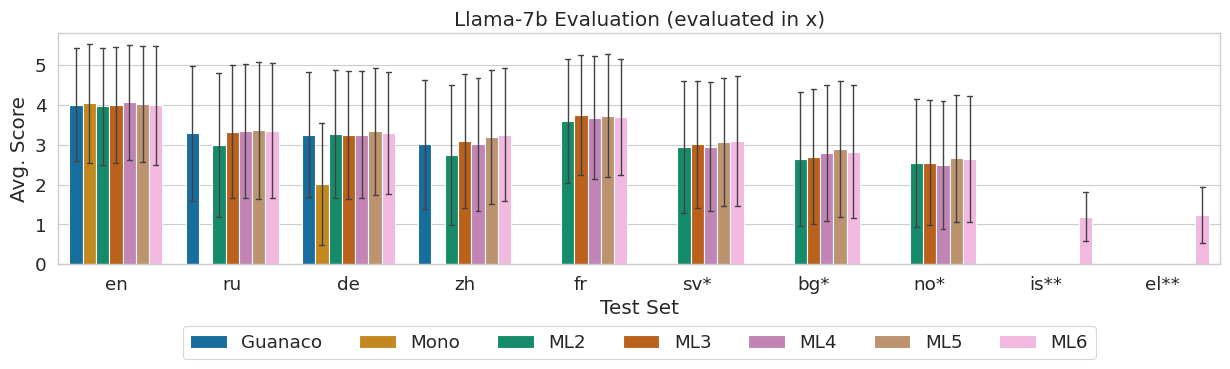

In [132]:

def plot_score_distribution(df, title=None, save_path=None):

    # for each test set, plot the distribution of eval_score for each model
    fig, ax = plt.subplots(figsize=(15, 3))
    
    test_sets = [l for l in ordered_test_sets if l in df['test_set'].unique()]
    model_names = df['model_name'].unique()
    print(model_names)
    # sns.boxplot(data=df, x='test_set', y='eval_score', hue='model_name', ax=ax)
    # sns.barplot(data=df, x='test_set', y='eval_score', hue='model_name', ax=ax)
    sns.barplot(data=df, x='test_set', y='eval_score', hue='model_name', ax=ax,  
                # errorbar=("ci", 95), capsize=0.3,
                errorbar='sd', capsize=0.3,
                err_kws={"linewidth": 1.0},
                alpha=1.0,
                order=test_sets,
                hue_order=model_names,
                )
    
    # sns.violinplot(data=df, x='test_set', y='eval_score', hue='model_name', ax=ax, 
    #                fill=True, density_norm="count", common_norm=True,
    #             #    split=True,
    #                inner="quart",
    #                dodge=True, gap=0.3,
    #                alpha=0.8,
    #             #    inner_kws=dict(box_width=4, whis_width=1, color=".8"),
    #                inner_kws=dict(color=".8"),
    #                )
    
    # apply hatches to certain bars
    # for p in ax.patches:
    #     print(p)

    # # remove bars from sorted that correspond to the legend
    # bars = [patch for patch in ax.patches if patch.xy != (0, 0)]

    # sorted_bars = sorted(bars, key=lambda bar: bar.get_x(), reverse=False)
    
    # # Create a dictionary to map each bar to its 'test_set' and 'model_name'
    # bar_info = {}
    # for i, test_set in enumerate(test_sets):
    #     for j, model_name in enumerate(model_names):
    # #         # The index of the bar in the patches list
    #         index = i * len(model_names) + j
    #         bar_info[sorted_bars[index]] = {'test_set': test_set, 'model_name': model_name}

    # # Loop over the bars and add a text label as a marker
    # for i, (bar, info) in enumerate(bar_info.items()):
    #     if info['test_set'] in training_langs[info['model_name'].split()[-1]]:
    #         bar.set_hatch('//')
    #     else:
    #         bar.set_hatch('')

    
    
    ax.set_xlabel('Test Set')
    ax.set_ylabel('Avg. Score')
    
    ax.set_title(title)

    # legend at bottom
    if len(test_sets) >= 6:
        ncols = len(model_names)
        y_offset = -0.45
    else:
        ncols = 3
        y_offset = -0.55
    ax.legend(loc='lower center', bbox_to_anchor=(0.5, y_offset), ncol=ncols)

    if save_path:
        fig.savefig(save_path, bbox_inches='tight', dpi=300)
        print(f'saved to {save_path}')

    return


sdf = df[df['model_name'].isin(['Llama-2 Mono', 'Llama-2 ML2', 'Llama-2 ML3', 'Llama-2 ML4', 'Llama-2 ML5', 'Llama-2 ML6/ca', 'Llama-2 Guanaco'])]
sdf = sdf[sdf['test_set'].isin(ordered_test_sets)]
sdf = sdf[ (sdf['eval_src'] == 'source') & (sdf['eval_tgt'] == 'system') ]
sdf['model_name'] = sdf['model_name'].str.replace('Llama-2 ', '').str.replace('/ca', '')

plot_score_distribution(
    sdf, 
    title='Llama-7b Evaluation (evaluated in x)',
    save_path='data/plots/llm_judge_7b_incremental_ml_wide.png'
    )

# plot_score_distribution(df[ ((df['eval_src'] == 'source_en') & (df['eval_tgt'] == 'system_en')) | (df['test_set'] == 'en') ], title='Evaluated in en')


Llama-2 70B Mono    9891
ML4                 9888
ML5                 9888
ML3                 9887
ML2                 9881
ML6                 9879
Name: model_name, dtype: int64
['Llama-2 70B Mono' 'ML2' 'ML3' 'ML4' 'ML5' 'ML6']
saved to data/plots/llm_judge_70b_incremental_mt_ml_wide.png


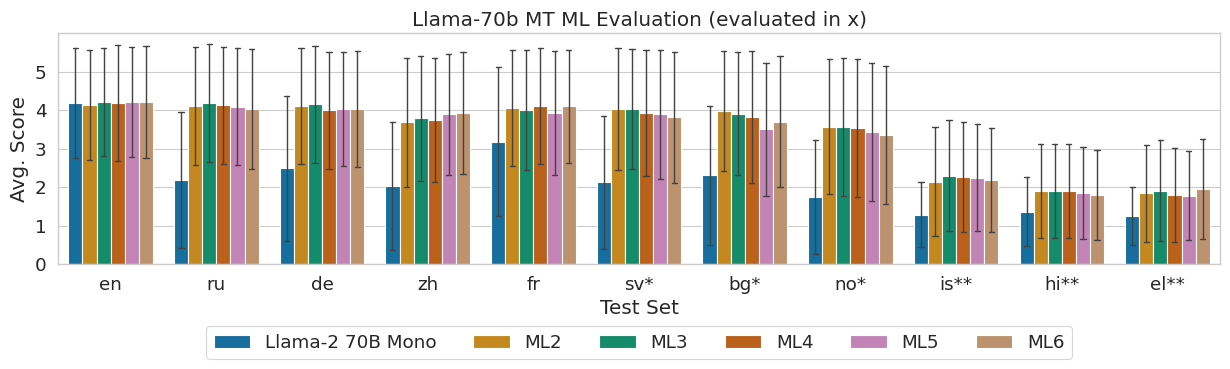

In [133]:
sdf = df[df['model_name'].isin(['Llama-2 70B Mono', 'Llama-2 70B MT ML2', 'Llama-2 70B MT ML3', 'Llama-2 70B MT ML4', 'Llama-2 70B MT ML5', 'Llama-2 70B MT ML6'])]
sdf = sdf[sdf['test_set'].isin(ordered_test_sets)]
sdf = sdf[ (sdf['eval_src'] == 'source') & (sdf['eval_tgt'] == 'system') ]
sdf['model_name'] = sdf['model_name'].str.replace('Llama-2 70B MT ', '')
# print(len(sdf))
print(sdf['model_name'].value_counts())
plot_score_distribution(
    sdf, 
    title='Llama-70b MT ML Evaluation (evaluated in x)',
    save_path='data/plots/llm_judge_70b_incremental_mt_ml_wide.png'
    )


In [134]:
# sdf = df[df['model_name'].isin(['Llama-2 MTOL ML6/ca'])]
# sdf = sdf[sdf['test_set'].isin(ordered_test_sets)]
# # sdf = sdf[ (sdf['eval_src'] == 'source') & (sdf['eval_tgt'] == 'system') ]
# # sdf['model_name'] = sdf['model_name'].str.replace('Llama-2 70B', '')
# # print(len(sdf))
# print(sdf['model_name'].value_counts())
# plot_score_distribution(
#     sdf, 
#     title='Llama-70b Evaluation (evaluated in x)',
#     save_path='data/plots/llm_judge_7b_incremental_ml_mtol_wide.png'
#     )

Llama-2 Mono    1798
ML3              900
ML4              900
ML5              900
ML6              900
ML2              898
Name: model_name, dtype: int64
['Llama-2 Mono' 'ML2' 'ML3' 'ML4' 'ML5' 'ML6']
saved to data/plots/llm_judge_7b_incremental_mt_ml_wide.png


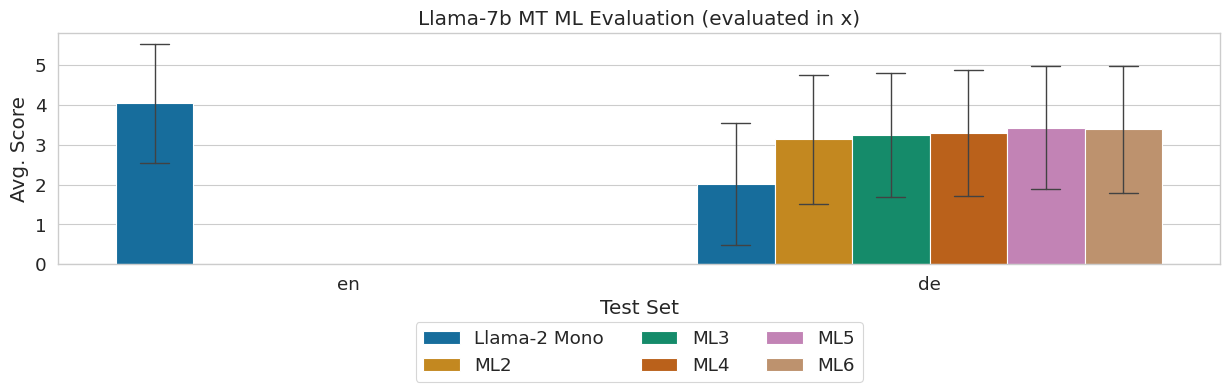

In [136]:
sdf = df[df['model_name'].isin(['Llama-2 Mono', 'Llama-2 MT ML2', 'Llama-2 MT ML3', 'Llama-2 MT ML4', 'Llama-2 MT ML5', 'Llama-2 MT ML6'])]
sdf = sdf[sdf['test_set'].isin(ordered_test_sets)]
sdf = sdf[ (sdf['eval_src'] == 'source') & (sdf['eval_tgt'] == 'system') ]
sdf['model_name'] = sdf['model_name'].str.replace('Llama-2 MT ', '')
# print(len(sdf))
print(sdf['model_name'].value_counts())
plot_score_distribution(
    sdf, 
    title='Llama-7b MT ML Evaluation (evaluated in x)',
    save_path='data/plots/llm_judge_7b_incremental_mt_ml_wide.png'
    )


Llama-2 ML5       900
Llama-2 MT ML3    900
Llama-2 MT ML4    900
Llama-2 MT ML6    900
Llama-2 ML2       899
Llama-2 ML3       899
Llama-2 ML4       899
Llama-2 MT ML2    898
Name: model_name, dtype: int64
de    7195
Name: test_set, dtype: int64
['Llama-2 ML2' 'Llama-2 ML3' 'Llama-2 ML4' 'Llama-2 ML5' 'Llama-2 MT ML2'
 'Llama-2 MT ML3' 'Llama-2 MT ML4' 'Llama-2 MT ML6']


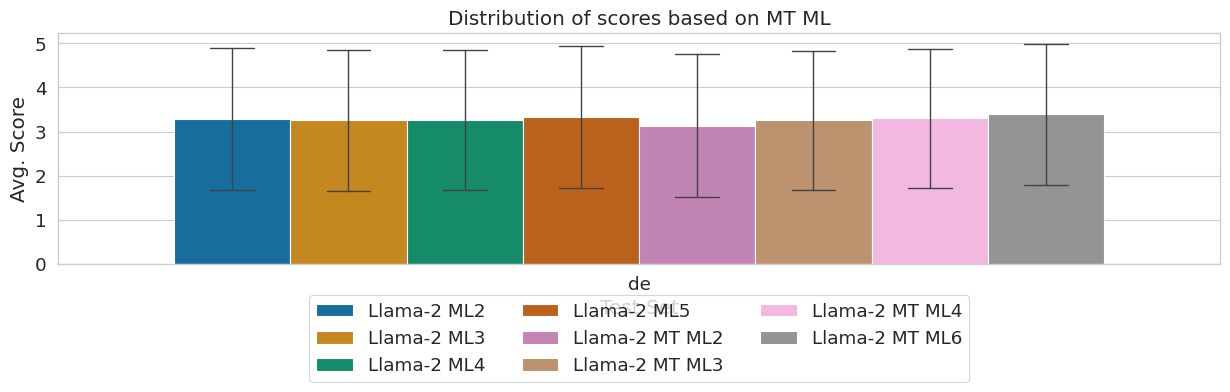

In [130]:
sdf = df[ (df['model_name'].isin([
    'Llama-2 ML2', 'Llama-2 MT ML2', 
    'Llama-2 ML3', 'Llama-2 MT ML3', 
    'Llama-2 ML4', 'Llama-2 MT ML4',
    'Llama-2 ML5', 'Llama-2 MT ML5'
    'Llama-2 ML6/ca', 'Llama-2 MT ML6'
    ])) ]
sdf = sdf[sdf['test_set'].isin(['de'])]
print(sdf['model_name'].value_counts())
print(sdf['test_set'].value_counts())

plot_score_distribution(
    sdf, 
    title='Distribution of scores based on MT ML',
    # save_path='data/plots/llm_judge_7b_translated_vs_direct_eval.png'
    )


saved to data/plots/llm_judge_7b_translated_vs_direct_eval.png
saved to data/plots/llm_judge_7b_s0_translated_vs_direct_eval.png
saved to data/plots/llm_judge_7b_s42_translated_vs_direct_eval.png
saved to data/plots/llm_judge_7b_s723_translated_vs_direct_eval.png


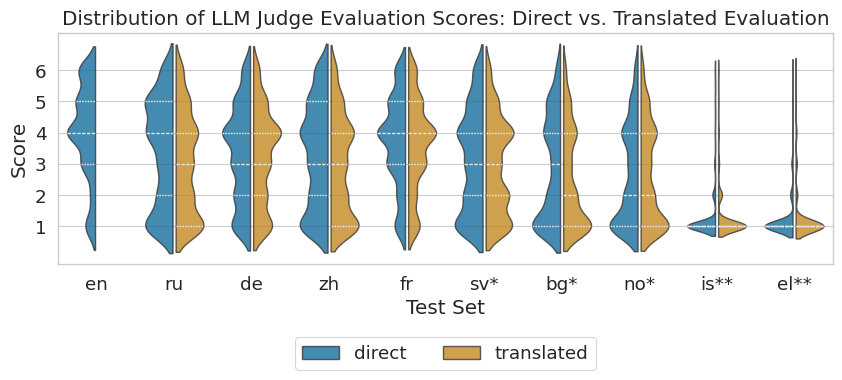

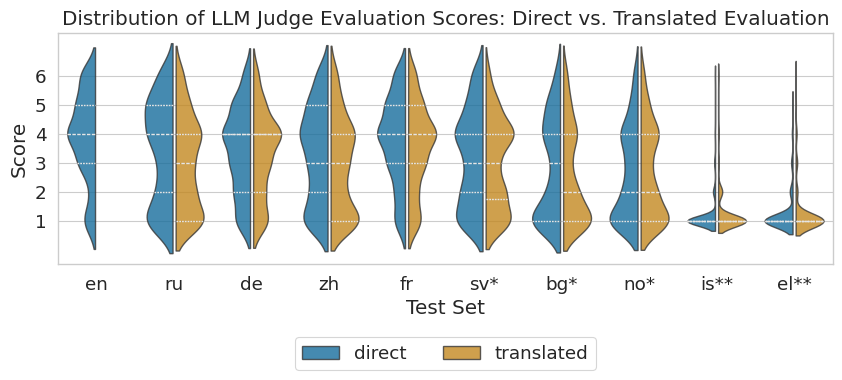

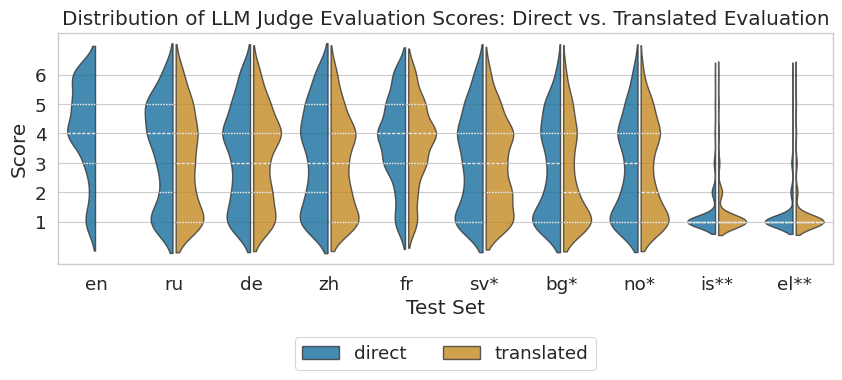

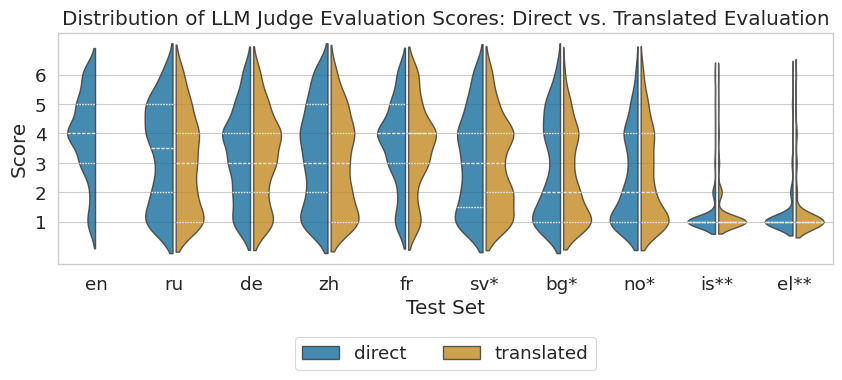

In [126]:

def plot_score_distribution_with_split_violins(df, title=None, save_path=None, hue='eval_type'):

    # for each test set, plot the distribution of eval_score for each model
    
    test_sets = [l for l in ordered_test_sets if l in df['test_set'].unique()]
    model_names = df['model_name'].unique()
    
    fig, ax = plt.subplots(figsize=(len(test_sets), 3))
    
    sns.violinplot(data=df, x='test_set', y='eval_score', hue=hue, ax=ax, 
                   fill=True, density_norm="count", common_norm=True,
                   split=True,
                   inner="quart",
                   dodge=True, gap=0.1,
                   alpha=0.8,
                   order=test_sets,
                #    inner_kws=dict(box_width=4, whis_width=1, color=".8"),
                   inner_kws=dict(color=".9"),
                   )
    
    ax.set_xlabel('Test Set')
    ax.set_ylabel('Score')
    
    # set y-ticks to integers 1-6
    ax.set_yticks(range(1, 7))

    ax.set_title(title)

    # place legend outside of plot at bottom with 3 columns
    ax.legend(loc='lower center', bbox_to_anchor=(0.5, -0.5), ncol=3)

    if save_path:
        fig.savefig(save_path, bbox_inches='tight', dpi=300)
        print(f'saved to {save_path}')

    return

sdf = df[ (df['model_name'].isin(['Llama-2 ML6/ca'])) ] 
sdf = sdf[sdf['test_set'].isin(ordered_test_sets)]

sdf['eval_type'] = sdf.apply(lambda x: "translated" if x['eval_src'] == 'source_en' else "direct", axis=1)

plot_score_distribution_with_split_violins(
    sdf, 
    title='Distribution of LLM Judge Evaluation Scores: Direct vs. Translated Evaluation',
    save_path='data/plots/llm_judge_7b_translated_vs_direct_eval.png'
    )

for seed in [0, 42, 723]:
    sdf = df[ (df['model_name'].isin(['Llama-2 ML6/ca'])) & (df['seed'] == seed) ] 
    sdf = sdf[sdf['test_set'].isin(ordered_test_sets)]

    sdf['eval_type'] = sdf.apply(lambda x: "translated" if x['eval_src'] == 'source_en' else "direct", axis=1)

    plot_score_distribution_with_split_violins(
        sdf, 
        title='Distribution of LLM Judge Evaluation Scores: Direct vs. Translated Evaluation',
        save_path=f'data/plots/llm_judge_7b_s{seed}_translated_vs_direct_eval.png'
        )

In [142]:
# def plot_grouped_bars(df, group_column):
#     """
#     Takes a pandas dataframe and a column name as the grouping variable.
#     Initialises a matplotlib figure and axis object and plots data as bar plots.
    
#     Args:
#     df (pd.DataFrame): The pandas dataframe containing the data.
#     group_column (str): The column name to group the data by.
    
#     Returns:
#     matplotlib figure and axis with the bar plot.
#     """
    
#     # Initialize the matplotlib figure and axis object
#     fig, ax = plt.subplots()
    
#     # Unique categories in the grouping variable
#     test_sets = [name for name in ordered_test_sets if name in df['test_set'].unique()]
#     models = test_set_data['model_name'].unique()

#     # expected number of bars
#     expected_num_bars = len(test_sets) * len(models)

#     x_ticks = np.arange(len(expected_num_bars))  # the label locations
#     print(x_ticks)

#     width = 0.1  # the width of the bars
#     multiplier = 0

#     for i, test_set in enumerate(test_sets):
#         # print(i, test_set)
#         # Filter the dataframe for the current category
#         test_set_data = df[df['test_set'] == test_set]

#         models = test_set_data['model_name'].unique()

#         for j, model in enumerate(models):
            
#             model_data = test_set_data[test_set_data['model_name'] == model]
            
#             scores_translated = model_data[ (model_data['eval_src'] == 'source_en') & (model_data['eval_tgt'] == 'system_en') ]['eval_score']
#             scores_untranslated = model_data[ (model_data['eval_src'] == 'source') & (model_data['eval_tgt'] == 'system') ]['eval_score']
    
#             # get average score for each model
#             scores_translated_mean = scores_translated.mean()
#             scores_untranslated_mean = scores_untranslated.mean()

#             # get standard error for each model
#             scores_translated_std = scores_translated.std()
#             scores_untranslated_std = scores_untranslated.std()

#             print(scores_translated_mean, scores_translated_std)
#             print(scores_untranslated_mean, scores_untranslated_std)
            
            
#             # plot translated scores and untranslated scores side by side
#             ax.bar(x_pos, scores_translated_mean, yerr=scores_translated_std, width=width, label=f'{model} tr', hatch='//')
#             # ax.bar(x_ticks[i] + width * multiplier + width, scores_untranslated_mean, yerr=scores_untranslated_std, width=width, label=model, hatch='')

#             multiplier += 1

#             # offset = width * multiplier
#             # print((x + offset))

#             # score_translated = ax.bar((x + offset), [scores_translated_mean], yerr=[scores_translated_std], width=width/0.5, label=model, hatch='//')
#             # print((x + offset))
#             # scores_untranslated = ax.bar((x + offset)+width/0.5, [scores_untranslated_mean], yerr=[scores_untranslated_std], width=width/0.5, label=model, hatch='')
#             # multiplier += 1
#             # ax.bar([test_set]+offset, [scores_translated_mean], yerr=[scores_translated_std], label=model, hatch='//')
#             # ax.bar([test_set]+offset, [scores_untranslated_mean], yerr=[scores_untranslated_std], label=model, hatch='')
#             # offset += 0.2
#             # ax.bar(x=model, height=scores_translated_mean, yerr=scores_translated_std, label='translated', alpha=0.5)
#         #         # The next bar plot should start on top of the previous one, so we update 'bottom'
#         # if bottom is None:
#         #     bottom = summary_data
#         # else:
#         #     bottom = bottom + summary_data
    
#     # set xtick labels as test sets
#     ax.set_xticks(x_ticks)
#     ax.set_xticklabels(test_sets)

#     # Add legend, labels and title
#     ax.legend(title=group_column)
#     ax.set_ylabel("Values")
#     ax.set_title("Grouped Bar Plot")
    
#     # place legend outside of plot at bottom with 3 columns
#     ax.legend(loc='lower center', bbox_to_anchor=(0.5, -0.5), ncol=3)
    
#     return fig, ax

# plot_grouped_bars(df[df['test_set'].isin(['en','de'])], 'test_set') 

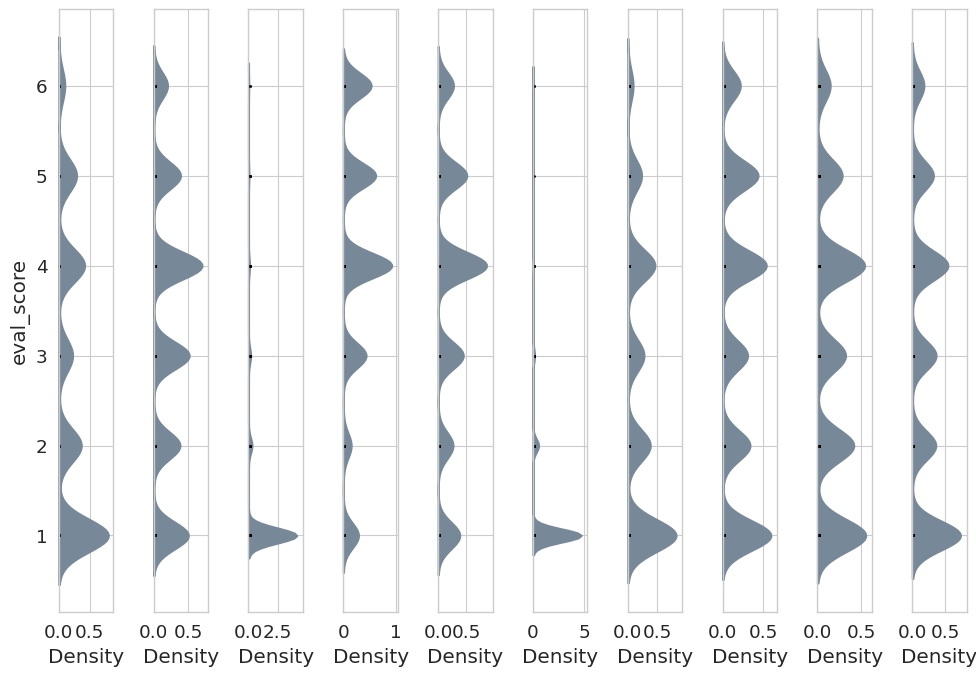

In [22]:
# https://stackoverflow.com/a/67091404/4649965

# def categorical_kde_plot(
#     df,
#     variable,
#     category,
#     category_order=None,
#     horizontal=False,
#     rug=True,
#     figsize=None,
# ):
#     """Draw a categorical KDE plot

#     Parameters
#     ----------
#     df: pd.DataFrame
#         The data to plot
#     variable: str
#         The column in the `df` to plot (continuous variable)
#     category: str
#         The column in the `df` to use for grouping (categorical variable)
#     horizontal: bool
#         If True, draw density plots horizontally. Otherwise, draw them
#         vertically.
#     rug: bool
#         If True, add also a sns.rugplot.
#     figsize: tuple or None
#         If None, use default figsize of (7, 1*len(categories))
#         If tuple, use that figsize. Given to plt.subplots as an argument.
#     """
#     if category_order is None:
#         categories = list(df[category].unique())
#     else:
#         categories = category_order[:]

#     figsize = (7, 1.0 * len(categories))

#     fig, axes = plt.subplots(
#         nrows=len(categories) if horizontal else 1,
#         ncols=1 if horizontal else len(categories),
#         figsize=figsize[::-1] if not horizontal else figsize,
#         sharex=horizontal,
#         sharey=not horizontal,
#     )

#     for i, (cat, ax) in enumerate(zip(categories, axes)):
#         sns.kdeplot(
#             data=df[df[category] == cat],
#             x=variable if horizontal else None,
#             y=None if horizontal else variable,
#             # kde kwargs
#             bw_adjust=0.5,
#             clip_on=False,
#             fill=True,
#             alpha=1,
#             linewidth=1.5,
#             ax=ax,
#             color="lightslategray",
#         )

#         keep_variable_axis = (i == len(fig.axes) - 1) if horizontal else (i == 0)

#         if rug:
#             sns.rugplot(
#                 data=df[df[category] == cat],
#                 x=variable if horizontal else None,
#                 y=None if horizontal else variable,
#                 ax=ax,
#                 color="black",
#                 height=0.025 if keep_variable_axis else 0.04,
#             )

#         # _format_axis(
#         #     ax,
#         #     cat,
#         #     horizontal,
#         #     keep_variable_axis=keep_variable_axis,
#         # )

#     plt.tight_layout()
#     plt.show()


# def _format_axis(ax, category, horizontal=False, keep_variable_axis=True):

#     # Remove the axis lines
#     ax.spines["top"].set_visible(False)
#     ax.spines["right"].set_visible(False)

#     if horizontal:
#         ax.set_ylabel(None)
#         lim = ax.get_ylim()
#         ax.set_yticks([(lim[0] + lim[1]) / 2])
#         ax.set_yticklabels([category])
#         if not keep_variable_axis:
#             ax.get_xaxis().set_visible(False)
#             ax.spines["bottom"].set_visible(False)
#     else:
#         ax.set_xlabel(None)
#         lim = ax.get_xlim()
#         ax.set_xticks([(lim[0] + lim[1]) / 2])
#         ax.set_xticklabels([category])
#         if not keep_variable_axis:
#             ax.get_yaxis().set_visible(False)
#             ax.spines["left"].set_visible(False)


# # test_df = sns.load_dataset("tips")
# # test_df
# # categorical_kde_plot(
# #     test_df,
# #     variable="tip",
# #     category="day",
# #     category_order=["Thur", "Fri", "Sat", "Sun"],
# #     horizontal=False,
# # )

# categorical_kde_plot(
#     df,
#     variable="eval_score",
#     category="test_set",
#     # category_order=["Thur", "Fri", "Sat", "Sun"],
#     horizontal=False,
# )

In [82]:
def get_generations(results_dir):
    dfs = []
    for generations_file in Path(results_dir).glob('*/*.llm_eval'):
        # print(eval_file)
        df = pd.read_json(generations_file, lines=True)
        model_name, test_set, prompt, seed = parse_filename(generations_file)
        df['model_name'] = model_name
        df['test_set'] = test_set
        df['context'] = prompt
        df['seed'] = seed
        dfs.append(df)
        
    df = pd.concat(dfs, axis=0, ignore_index=False)

    # move input_file, model_name and seed to front
    cols = df.columns.tolist()
    cols.insert(0, cols.pop(cols.index('model_name')))
    cols.insert(1, cols.pop(cols.index('test_set')))
    cols.insert(2, cols.pop(cols.index('seed')))
    # cols.insert(0, df.ndex)
    df = df.reindex(columns=cols)

    return df

gen_df = get_generations(results_dir)

gen_df.replace({'model_name': name_map, 'test_set': name_map}, inplace=True)
print(len(gen_df))
print(gen_df.columns)
gen_df.head()

# data/outputs/llama_2_7b_hf_zh_merged/alpaca_eval_instructions_zh-none-guanaco_prompt-s42-k50-p0.9-t0.8-b8-gpt_3.5_turbo-l50.llm_eval

3750
Index(['model_name', 'test_set', 'seed', 'prompt', 'system', 'finish_reason',
       'source', 'secs', 'source_lang', 'system_lang', 'id',
       'gpt-3.5-turbo-judgement', 'gpt-3.5-turbo-justification',
       'gpt-3.5-turbo-cost', 'context', 'gpt-4-judgement',
       'gpt-4-justification', 'gpt-4-cost'],
      dtype='object')


,model_name,test_set,seed,prompt,system,finish_reason,source,secs,source_lang,system_lang,id,gpt-3.5-turbo-judgement,gpt-3.5-turbo-justification,gpt-3.5-turbo-cost,context,gpt-4-judgement,gpt-4-justification,gpt-4-cost
0,Llama-2 ML6/de,de,42,"### Human: ""Warum fühlt man sich durch Wärme m...",Die Frage nach dem Verständnis der psychologis...,stop,"""Warum fühlt man sich durch Wärme müde?""",1.623084,deu_Latn,deu_Latn,193,Excellent,"informative, interesting",0.001520,guanaco_prompt,NaN,NaN,NaN
1,Llama-2 ML6/de,de,42,"### Human: ""Erklären Sie, was das unterstriche...","Für Kinder ist das unterstrichene Wort ""ein Ve...",stop,"""Erklären Sie, was das unterstrichene Wort für...",0.935782,deu_Latn,deu_Latn,719,Excellent,"informative, interesting",0.001094,guanaco_prompt,NaN,NaN,NaN
2,Llama-2 ML6/de,de,42,"### Human: ""Eins Eins war ein Rennpferd. Zwei ...","In dieser Geschichte gibt es zwei Pferde, ein ...",stop,"""Eins Eins war ein Rennpferd. Zwei Zwei war au...",1.396412,deu_Latn,deu_Latn,169,Excellent,"informative, interesting",0.000906,guanaco_prompt,NaN,NaN,NaN
3,Llama-2 ML6/de,de,42,"### Human: ""Dir wird eine Beschreibung gegeben...",Als Reaktion auf die geplante russische Invasi...,stop,"""Dir wird eine Beschreibung gegeben, die eine ...",1.525187,deu_Latn,deu_Latn,523,Fail,language,0.001013,guanaco_prompt,NaN,NaN,NaN
4,Llama-2 ML6/de,de,42,"### Human: ""Dir wird ein Thema für einen Insta...","""Beitrag zum Instagram-Beitrag über Frauen in ...",stop,"""Dir wird ein Thema für einen Instagram-Beitra...",1.177709,deu_Latn,deu_Latn,537,Excellent,"informative, interesting",0.000775,guanaco_prompt,NaN,NaN,NaN


In [83]:
gen_df['model_name_test_set'] = gen_df['model_name'] + ' ' + gen_df['test_set']

fig_width: 6, fig_height: 4.0, subplot_height: 0.16666666666666666
ML6/zh zh: {'Excellent': 24.0, 'Pass': 21.333333333333336, 'Fail': 54.666666666666664}
ML6/zh ru: {'Excellent': 17.333333333333336, 'Pass': 14.666666666666666, 'Fail': 68.0}
ML6/zh is: {'Excellent': 1.3333333333333335, 'Pass': 15.333333333333332, 'Fail': 83.33333333333334}
ML6/zh hi: {'Excellent': 9.333333333333334, 'Pass': 22.666666666666664, 'Fail': 68.0}
ML6/zh fr: {'Excellent': 67.33333333333333, 'Pass': 12.0, 'Fail': 20.666666666666668}
ML6/zh en: {'Excellent': 82.66666666666667, 'Pass': 4.666666666666667, 'Fail': 12.666666666666668}
ML6/zh el: {'Excellent': 0.6666666666666667, 'Pass': 11.333333333333332, 'Fail': 88.0}
ML6/zh de: {'Excellent': 70.0, 'Pass': 18.0, 'Fail': 12.0}
ML6/ru zh: {'Excellent': 33.33333333333333, 'Pass': 18.0, 'Fail': 48.66666666666667}
ML6/ru ru: {'Excellent': 14.000000000000002, 'Pass': 11.333333333333332, 'Fail': 74.66666666666667}
ML6/ru is: {'Excellent': 4.666666666666667, 'Pass': 5.333

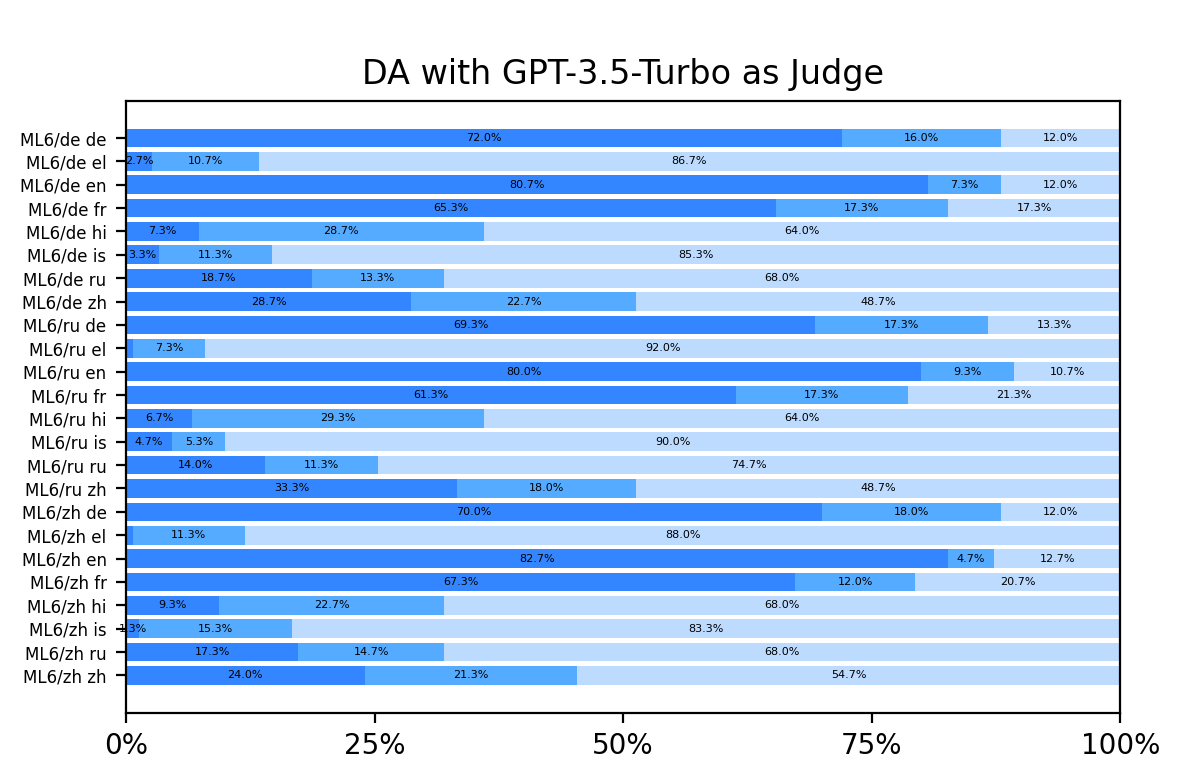

In [ ]:
def calculate_legend_bbox(subplot_height, figsize_height, margin_fraction=0.1):
    # Calculate the margin as a fraction of the subplot height
    margin = margin_fraction * subplot_height

    # Calculate the bbox_to_anchor value
    bbox_to_anchor = (0.5, -margin / figsize_height)

    return bbox_to_anchor

def calculate_figure_height(num_items, target_aspect_ratio):
    # Calculate the width of the figure based on the target aspect ratio
    fig_width = 6
    fig_height = fig_width / target_aspect_ratio

    # Calculate the subplot height based on the number of items
    subplot_height = fig_height / num_items

    return fig_width, fig_height, subplot_height

# plot the judgemtnts for each model
def plot_judgements(df, judge='GPT-3.5-Turbo', title=None, task_id='', output_dir=None, target_aspect_ratio=1.5, margin_fraction=0.5):
    """
    
    """
    
    # models = df['model_name'].unique().tolist()[::-1]
    test_sets = df['model_name_test_set'].unique().tolist()[::-1]

    # Calculate the figure width, height, and subplot height
    fig_width, fig_height, subplot_height = calculate_figure_height(len(test_sets), target_aspect_ratio=target_aspect_ratio)
    print(f'fig_width: {fig_width}, fig_height: {fig_height}, subplot_height: {subplot_height}')

    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(fig_width, fig_height), sharey=True, sharex=True, dpi=200, tight_layout=True)

    colors = {'Excellent': '#0068FF', 'Pass': '#2B96FF', 'Fail': '#ABD2FF'}

    # for i, model in enumerate(models):
        # print(model)
    for j, test_set in enumerate(test_sets):
        # print(test_set)
        # sdf = df[(df['model_name'] == model) & (df['test_set'] == test_set)]
        sdf = df[df['model_name_test_set'] == test_set]
        # print(len(sdf))
        # print(sdf.columns)
        if judge == 'GPT-3.5-Turbo':
            results = sdf['gpt-3.5-turbo-judgement'].value_counts(normalize=True).to_dict()
        elif judge == 'GPT-4':
            results = sdf['gpt-4-judgement'].value_counts(normalize=True).to_dict()
        else:
            raise ValueError(f'Unknown judge: {judge}')
        
        # sort order: 'Excellent, Pass, Fail'
        results = {k: results.get(k, 0.0) for k in ['Excellent', 'Pass', 'Fail']}
        # multiply by 100 to get percentage
        results = {k: v * 100 for k, v in results.items()}

        print(f'{test_set}: {results}')

        prev_val = 0
        for k, v in results.items():

            ax.barh(y=j, width=v, height=0.8, left=prev_val, 
                    color=colors[k], alpha=0.8, # set the color of each bar individually
                    label=k if j == 0 else "", # label the first bar in each stack with the model name
                    )
            
            # label bar with value
            if v > 1:
                ax.text(x=prev_val + v/2, y=j, s=f'{v:.1f}%', ha='center', va='center', fontsize=4)

            # add the value of each bar to the previous value
            prev_val += v
    
            # # hide legend for all but the first model
            # if i == 0 and j > 0:
            #     ax.get_legend().remove()


    # Set the y-ticks to be the model names
    ax.set_yticks(np.arange(len(test_sets)), test_sets, fontsize=6)
    ax.set_xlabel('')

    ax.set_xticks([0, 25, 50, 75, 100], ['0%', '25%', '50%', '75%', '100%'], minor=False)
    # ax.set_xticklabels()

    # remove x-axis ticks
    # ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
    
    # # put the legend out of the plot and center it
    # # if len(models) > 2:
    # bbox_to_anchor = calculate_legend_bbox(subplot_height, fig_height, margin_fraction=margin_fraction)
    # print(bbox_to_anchor)
    # ax.legend(bbox_to_anchor=bbox_to_anchor, loc='lower center', ncol=3, frameon=False)# , fontsize=8)
    # # else:
    # #     ax.legend(bbox_to_anchor=(0.5, -0.2), loc='lower center', ncol=3, frameon=False, fontsize=8)

    # Adjust the margins
    plt.margins(y=0.05, x=0.0)

    # title of plot
    if not title:
        ax.set_title(f'{task_id}\nDA with {judge} as Judge')
    else:
        ax.set_title(title)

    if output_dir is not None:
        outfile = Path(output_dir) / f'da_judge_{judge}-{task_id}.png'
        plt.savefig(outfile, dpi=300, bbox_inches='tight')
        print(f'Saved to {outfile}')

    return

plot_judgements(gen_df, judge='GPT-3.5-Turbo')

fig_width: 6, fig_height: 4.0, subplot_height: 0.16666666666666666
ML6/zh zh: {'Excellent': 70.0, 'Pass': 8.0, 'Fail': 22.0}
ML6/zh ru: {'Excellent': 0.0, 'Pass': 0.0, 'Fail': 0.0}
ML6/zh is: {'Excellent': 0.0, 'Pass': 0.0, 'Fail': 0.0}
ML6/zh hi: {'Excellent': 0.0, 'Pass': 0.0, 'Fail': 0.0}
ML6/zh fr: {'Excellent': 0.0, 'Pass': 0.0, 'Fail': 0.0}
ML6/zh en: {'Excellent': 0.0, 'Pass': 0.0, 'Fail': 0.0}
ML6/zh el: {'Excellent': 0.0, 'Pass': 0.0, 'Fail': 0.0}
ML6/zh de: {'Excellent': 0.0, 'Pass': 0.0, 'Fail': 0.0}
ML6/ru zh: {'Excellent': 0.0, 'Pass': 0.0, 'Fail': 0.0}
ML6/ru ru: {'Excellent': 66.0, 'Pass': 6.0, 'Fail': 28.000000000000004}
ML6/ru is: {'Excellent': 0.0, 'Pass': 0.0, 'Fail': 0.0}
ML6/ru hi: {'Excellent': 0.0, 'Pass': 0.0, 'Fail': 0.0}
ML6/ru fr: {'Excellent': 0.0, 'Pass': 0.0, 'Fail': 0.0}
ML6/ru en: {'Excellent': 0.0, 'Pass': 0.0, 'Fail': 0.0}
ML6/ru el: {'Excellent': 0.0, 'Pass': 0.0, 'Fail': 0.0}
ML6/ru de: {'Excellent': 0.0, 'Pass': 0.0, 'Fail': 0.0}
ML6/de zh: {'Excell

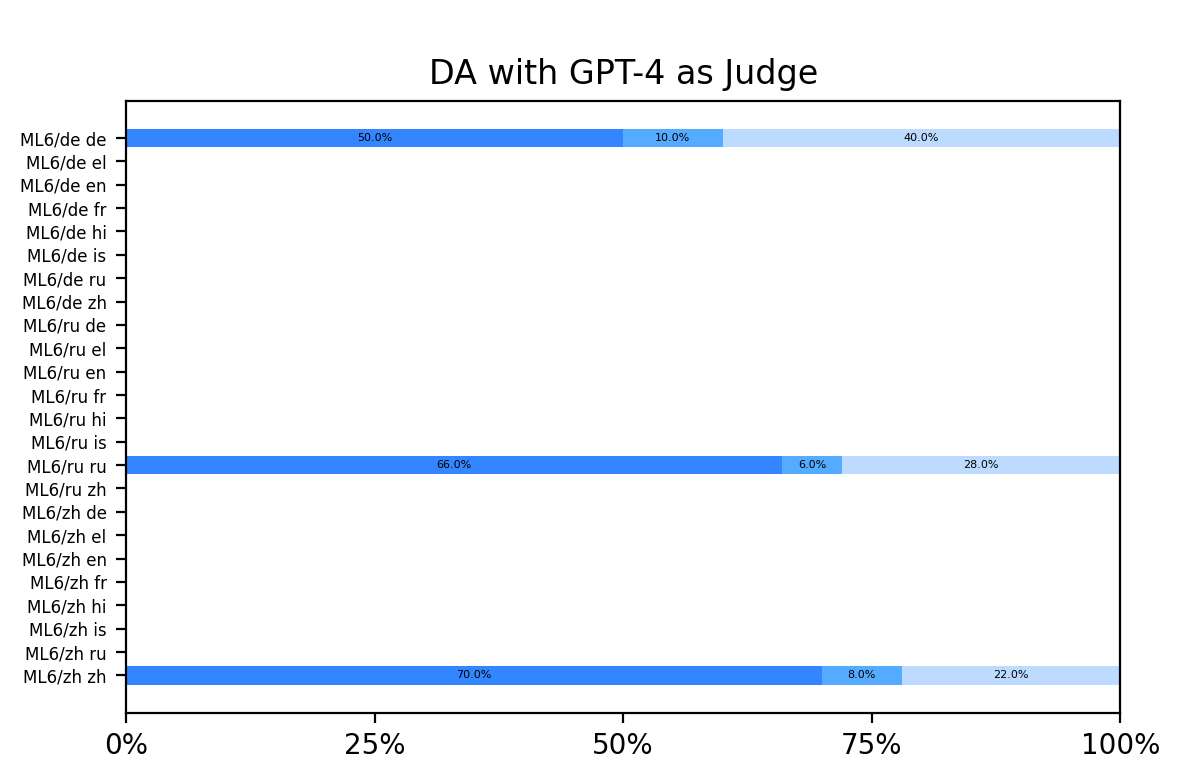

In [62]:
plot_judgements(gen_df, judge='GPT-4')


In [67]:
gen_df['gpt-4-justification'].value_counts()

gpt-4-justification
informative, interesting, correct                                                                                                                                                                                                                                   42
informative, interesting, and correct                                                                                                                                                                                                                               20
incorrect information                                                                                                                                                                                                                                                5
informative, correct, and detailed                                                                                                                                                             

In [68]:
gen_df['gpt-3.5-turbo-justification'].value_counts()

gpt-3.5-turbo-justification
language                                                                                                                                                                                                 1810
informative, interesting                                                                                                                                                                                 1112
grammatical, sufficient                                                                                                                                                                                   263
grammatical, informative                                                                                                                                                                                   92
grammatical                                                                                                                                         

In [14]:
# inspect off-target generations in output files

def get_generations(results_dir):
    dfs = []
    for generations_file in Path(results_dir).glob('*/*.jsonl'):
        # print(eval_file)
        df = pd.read_json(generations_file, lines=True)
        model_name, test_set, prompt, seed = parse_filename(generations_file)
        df['model_name'] = model_name
        df['test_set'] = test_set
        df['context'] = prompt
        df['seed'] = seed
        dfs.append(df)
        
    df = pd.concat(dfs, axis=0, ignore_index=False)

    # move input_file, model_name and seed to front
    cols = df.columns.tolist()
    cols.insert(0, cols.pop(cols.index('model_name')))
    cols.insert(1, cols.pop(cols.index('test_set')))
    cols.insert(2, cols.pop(cols.index('seed')))
    # cols.insert(0, df.ndex)
    df = df.reindex(columns=cols)

    return df

gen_df = get_generations(results_dir)
gen_df

,model_name,test_set,seed,prompt,system,finish_reason,source,secs,source_lang,system_lang,context
0,llama_2_7b_hf_ml1_merged,alpaca_eval_instructions_de,0,"### Human: ""Wie lauten die Namen einiger berüh...",Here are some famous actors who began their ca...,stop,"""Wie lauten die Namen einiger berühmter Schaus...",2.562441,deu_Latn,eng_Latn,guanaco_prompt
1,llama_2_7b_hf_ml1_merged,alpaca_eval_instructions_de,0,"### Human: ""Wie haben die US-Bundesstaaten ihr...",Die Staaten der Vereinigten Staaten von Amerik...,length,"""Wie haben die US-Bundesstaaten ihre Namen erh...",2.562441,deu_Latn,deu_Latn,guanaco_prompt
2,llama_2_7b_hf_ml1_merged,alpaca_eval_instructions_de,0,"### Human: ""Hallo, meine Schwester und ihre Fr...",Sure! Kickball is a game that combines element...,stop,"""Hallo, meine Schwester und ihre Freundinnen m...",2.562441,deu_Latn,eng_Latn,guanaco_prompt
3,llama_2_7b_hf_ml1_merged,alpaca_eval_instructions_de,0,"### Human: ""Was sind einige coole Musikstücke ...","""Die 20er Jahre waren eine Zeit des wirtschaft...",stop,"""Was sind einige coole Musikstücke aus den 192...",2.562441,deu_Latn,deu_Latn,guanaco_prompt
4,llama_2_7b_hf_ml1_merged,alpaca_eval_instructions_de,0,"### Human: ""Wie verpacke ich ein Geschenk orde...","""Ein Geschenk verpacken ist eine wichtige Sach...",stop,"""Wie verpacke ich ein Geschenk ordentlich?""",2.562441,deu_Latn,deu_Latn,guanaco_prompt
...,...,...,...,...,...,...,...,...,...,...,...
800,llama_2_7b_hf_zh_merged,alpaca_eval_instructions_zh,723,### Human: 为一段YouTube视频撰写剧本，探索爵士乐的历史和文化意义。### ...,"[推荐视频]\n\n<iframe width=""560"" height=""315"" src...",stop,为一段YouTube视频撰写剧本，探索爵士乐的历史和文化意义。,3.112936,NaN,NaN,guanaco_prompt
801,llama_2_7b_hf_zh_merged,alpaca_eval_instructions_zh,723,### Human: 撰写一篇有趣的旅行博客文章，介绍最近去夏威夷的旅行，重点突出文化体验和...,![](https://cdn-images-1.medium.com/max/1600/1...,stop,撰写一篇有趣的旅行博客文章，介绍最近去夏威夷的旅行，重点突出文化体验和必看景点。,3.112936,NaN,NaN,guanaco_prompt
802,llama_2_7b_hf_zh_merged,alpaca_eval_instructions_zh,723,### Human: 为一部最近上映的科幻电影撰写一个引人入胜的影评，讨论其剧情、角色和特效...,电影《黑洞之魂》简介\n\n《黑洞之魂》是一部2021年上映的科幻电影，由迈克尔·杰克逊导演...,stop,为一部最近上映的科幻电影撰写一个引人入胜的影评，讨论其剧情、角色和特效。,3.112936,NaN,NaN,guanaco_prompt
803,llama_2_7b_hf_zh_merged,alpaca_eval_instructions_zh,723,### Human: 为一集讨论流媒体平台对音乐产业影响的播客脚本进行构建。### Assi...,[一句话简介]\n\n我们将讨论流媒体平台对音乐产业的影响，并对此进行探讨。我们将从三个角度...,stop,为一集讨论流媒体平台对音乐产业影响的播客脚本进行构建。,3.112936,NaN,NaN,guanaco_prompt


In [15]:
# def inspect_longer_strings(text):
#     # escape newlines
#     text = text.replace('\n', '\\n')
#     text_ = text[:100]
#     if len(text) > len(text_):
#         text_ += '...'
#     return text_

# for i, row in gen_df.iterrows():
#     expected_lang = row['test_set'][-2:]
#     # print(expected_lang)
#     if row['system_lang'] != expected_lang:
#         print(i, inspect_longer_strings(row['source']))
#         print(row['system_lang'], inspect_longer_strings(row['system']))
#         print('*****')
#         # break

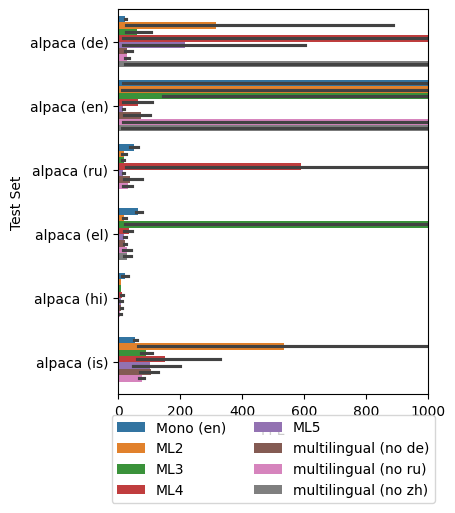

In [16]:
# plot bar plots of lang_match

fig, ax = plt.subplots(figsize=(4, 5))

sns.barplot(x='ppl', y='test_set', hue='model_name', errorbar='ci', orient='h', data=df, ax=ax)

ax.set_xlabel('PPL')
ax.set_ylabel('Test Set')

ax.set_xlim(0, 1000)
# legend at bottom
ax.legend(loc='lower center', bbox_to_anchor=(0.5, -0.3), ncol=2)



In [ ]:
# # sort models given the order in name_map
# model_names = df['model_name'].unique()
# ordered_model_names = sorted(model_names, key=lambda x: list(name_map.values()).index(x))
# print(ordered_model_names)
# ordered_test_sets = sorted(df['test_set'].unique())
# print(ordered_test_sets)
# ordered_seeds = sorted(df['seed'].unique())
# print(ordered_seeds)

# def apply_sort(df):

#     df['model_name'] = pd.Categorical(df['model_name'], ordered_model_names)

#     df['context'] = pd.Categorical(df['context'], ordered_contexts)

#     df = df.sort_values(by=['test_set', 'model_name', 'context', 'seed'])

#     # Convert the columns back to their original data types
#     df['model_name'] = df['model_name'].astype(str)
#     df['context'] = df['context'].astype(str)
        
#     df = df.reset_index(drop=True)

#     return df

# # drop columns containing any NaN values
# # df = df.dropna(axis=1, how='any')

# # sort dataframe
# df = apply_sort(df)

# # store sort order
# custom_sort_index = df.index.tolist()
# df['idx'] = custom_sort_index
# print(df.columns)
# df.head(4)